# mount drive, pip install, import

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install xgboost lightgbm shap tableone missingpy missingno optuna

import os
import logging
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import optuna
from sklearn.model_selection import cross_val_score

import shap
import xgboost as xgb
import lightgbm as lgb
from lightgbm.callback import log_evaluation

from scipy.sparse import csr_matrix

from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import (
    roc_curve, auc, matthews_corrcoef, accuracy_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, classification_report, f1_score
)
from sklearn.linear_model import LogisticRegression
from matplotlib.backends.backend_pdf import PdfPages


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.4/383.4 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 9.6 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [3]:
print(f"XGBoost version: {xgb.__version__}")

XGBoost version: 2.1.3


# functions

## adfinfo()

In [4]:
#check dataframe
def adfinfo(adf):
    print(f"Shape :{adf.shape}")
    print(f"Columns: {adf.columns}")
    print(f"Data types: {adf.dtypes}")
    print(f"Missing values: {adf.isna().sum()}")

## stats_pdf()

In [5]:
def stats_pdf(adf, output_pdf="boxplots_starting.pdf"):
    """
    Computes statistics for the adf DataFrame and saves them into a single PDF file.
    """
    excluded_columns = [col for col in adf.columns if "subject_id" in col.lower() or
                        "stay_id" in col.lower() or
                        "date" in col.lower()]
    filtered_adf = adf.drop(columns=excluded_columns, errors="ignore")


    stats_list = []
    for col in filtered_adf.columns:
        if pd.api.types.is_numeric_dtype(filtered_adf[col]):
            col_stats = {
                "Column": col,
                "Type": "Numerical",
                "Mean": round(filtered_adf[col].mean(skipna=True), 2),
                "Variance": round(filtered_adf[col].var(skipna=True), 2),
                "Std Dev": round(filtered_adf[col].std(skipna=True), 2),
                "Median": round(filtered_adf[col].median(skipna=True), 2),
                "Min": round(filtered_adf[col].min(skipna=True), 2),
                "Max": round(filtered_adf[col].max(skipna=True), 2),
                "Sum": round(filtered_adf[col].sum(skipna=True), 2),
                "Count": filtered_adf[col].notnull().sum()
            }
        else:
            col_stats = {
                "Column": col,
                "Type": "Categorical",
                "Mean": None,
                "Variance": None,
                "Std Dev": None,
                "Median": None,
                "Min": None,
                "Max": None,
                "Sum": None,
                "Count": filtered_adf[col].notnull().sum()
            }

        stats_list.append(col_stats)

    stats_df = pd.DataFrame(stats_list)


    with PdfPages(output_pdf) as pdf:
        fig, ax = plt.subplots(figsize=(12, len(stats_df) * 0.5 + 2))
        ax.axis('tight')
        ax.axis('off')
        table = ax.table(
            cellText=stats_df.values,
            colLabels=stats_df.columns,
            loc='center',
            cellLoc='center'
        )
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.auto_set_column_width(col=list(range(len(stats_df.columns))))
        plt.title("Summary Statistics", fontsize=14, weight="bold")
        pdf.savefig(fig)
        plt.close()

        for col in filtered_adf.select_dtypes(include='number').columns:
            fig, ax = plt.subplots(figsize=(8, 4))
            filtered_adf[col].hist(bins=20, grid=False, ax=ax)
            ax.set_title(f"Histogram of {col}")
            ax.set_xlabel(col)
            ax.set_ylabel("Frequency")
            pdf.savefig(fig)
            plt.close()

            fig, ax = plt.subplots(figsize=(8, 4))
            filtered_adf.boxplot(column=col, ax=ax)
            ax.set_title(f"Boxplot of {col}")
            ax.set_ylabel(col)
            pdf.savefig(fig)
            plt.close()

    print(f"Analysis and graphs have been saved to '{output_pdf}'.")

## save_to_csv()

In [6]:


def save_to_csv(data, file_name, sparse=False):
    """
    Saves a Pandas DataFrame or sparse matrix to a CSV file.

    Parameters:
    - data (pd.DataFrame or csr_matrix): The data to save. Can be a Pandas DataFrame or a sparse matrix.
    - file_name (str): The name of the CSV file (e.g., 'output.csv').
    - sparse (bool): If True, saves the sparse matrix in a compact sparse format; otherwise, converts to dense.

    Returns:
    - None
    """
    try:
        if isinstance(data, pd.DataFrame):

            data.to_csv(file_name, index=False)
        elif isinstance(data, csr_matrix):
            if sparse:
                sparse_df = pd.DataFrame({
                    'row': data.nonzero()[0],
                    'col': data.nonzero()[1],
                    'value': data.data
                })
                sparse_df.to_csv(file_name, index=False)
            else:
                dense_df = pd.DataFrame(data.toarray())
                dense_df.to_csv(file_name, index=False)
        else:
            raise ValueError("Input data must be a Pandas DataFrame or a sparse matrix (csr_matrix).")

        print(f"Data saved successfully to {file_name}")
    except Exception as e:
        print(f"An error occurred while saving the data: {e}")

## map_categorical()

In [7]:
def map_categorical(X):
    X = X.copy()

    diagnosis_mapping = {'Sepsis': 1, 'SIRS': 0}
    X['diagnosis'] = X['diagnosis'].map(diagnosis_mapping)

    gender_mapping = {'M': 1, 'F': 0}
    X['gender'] = X['gender'].map(gender_mapping)

    return X

## zmap_categorical()

In [8]:
def zmap_categorical(Z):
    Z = Z.copy()

    # Map 'diagnosis' to binary
    diagnosis_mapping = {'Sepsis': 1, 'SIRS': 0}
    Z['diagnosis'] = Z['diagnosis'].map(diagnosis_mapping)

    # Map 'gender' to binary
    gender_mapping = {'M': 1, 'F': 0}
    Z['gender'] = Z['gender'].map(gender_mapping)

    # Map 'language' to binary
    Z['language'] = Z['language'].apply(lambda x: 1 if x == 'English' else 0)

    def map_race(x):
        if pd.isnull(x):
            return 0  # Other
        x = x.upper()
        if 'HISPANIC' in x or 'LATINO' in x:
            return 1  # Hispanic
        elif 'BLACK' in x or 'AFRICAN' in x:
            return 2  # Black
        elif 'ASIAN' in x:
            return 3  # Asian
        elif 'WHITE' in x:
            return 4  # White
        else:
            return 0  # Other

    Z['race'] = Z['race'].apply(map_race)

    def map_insurance(x):
        if pd.isnull(x):
            return 0  # No pay/Other
        x = x.upper()
        if x == 'PRIVATE':
            return 3
        elif x == 'MEDICARE':
            return 2
        elif x == 'MEDICAID':
            return 1
        else:
            return 0  # No pay/Other

    Z['insurance'] = Z['insurance'].apply(map_insurance)

    return Z

## analyze_missing_by_demographics()

In [9]:
def analyze_missing_by_demographics(df, demographics_cols, missing_count_col='missing_count'):
    missing_analysis = df.groupby(demographics_cols)[missing_count_col].mean().reset_index()

    missing_analysis.rename(columns={missing_count_col: 'Average Missing Count'}, inplace=True)

    missing_analysis = missing_analysis.sort_values(by='Average Missing Count', ascending=False)

    return missing_analysis

## test_mcar()

In [10]:
import numpy as np
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
import missingno as msno

def test_mcar_with_visualization(df, demographics, plot=True):
    if plot:
        plt.figure(figsize=(10, 6))
        msno.matrix(df)
        plt.title("Missing Data Matrix", fontsize=16)
        plt.show()

        plt.figure(figsize=(10, 6))
        msno.bar(df)
        plt.title("Missing Data Bar Plot", fontsize=16)
        plt.show()

        plt.figure(figsize=(10, 6))
        msno.heatmap(df)
        plt.title("Missing Data Heatmap", fontsize=16)
        plt.show()

        plt.figure(figsize=(10, 6))
        msno.dendrogram(df)
        plt.title("Missing Data Dendrogram", fontsize=16)
        plt.show()


    missing_analysis = df.groupby(demographics)['missing_count'].mean().reset_index()
    missing_analysis.rename(columns={'missing_count': 'Average Missing Count'}, inplace=True)
    missing_analysis.sort_values(by='Average Missing Count', ascending=False, inplace=True)

    missing_indicator = df.isnull().astype(int)

    missing_indicator = missing_indicator.loc[:, missing_indicator.sum(axis=0) > 0]
    if missing_indicator.empty:
        raise ValueError("No missing values found in the dataset for the MCAR test.")

    observed_freqs = np.dot(missing_indicator.T, (1 - missing_indicator))

    observed_freqs = observed_freqs[~(observed_freqs == 0).all(axis=1), :]
    observed_freqs = observed_freqs[:, ~(observed_freqs == 0).all(axis=0)]
    if observed_freqs.size == 0:
        raise ValueError("The contingency table is empty after filtering zero rows/columns.")

    chi2_stat, p_value, _, _ = chi2_contingency(observed_freqs, correction=False)

    return p_value, missing_analysis

## test_mnar()

In [11]:
from sklearn.preprocessing import StandardScaler

def test_mnar(df, columns_to_test=None, max_iter=1000, threshold=0.6):
    if columns_to_test is None:
        columns_to_test = df.columns

    results = {}
    numeric_cols = df.select_dtypes(include=[np.number]).columns

    for col in columns_to_test:
        if col == 'missing_count':
            continue
        missing_mask = df[col].isnull().astype(int)

        if missing_mask.nunique() < 2:
            results[col] = {
                'auc': None,
                'MNAR_suspected': None,
                'note': 'No variation in missingness for this column.'
            }
            continue

        other_cols = [c for c in df.columns if c != col and c != 'missing_count']

        X = df[other_cols].fillna(df[other_cols].mean())
        y = missing_mask

        numeric_intersect = [c for c in X.columns if c in numeric_cols]

        scaler = StandardScaler()
        X_scaled = X.copy()
        X_scaled[numeric_intersect] = scaler.fit_transform(X_scaled[numeric_intersect])

        model = LogisticRegression(max_iter=max_iter)
        try:
            model.fit(X_scaled, y)
            y_pred_prob = model.predict_proba(X_scaled)[:, 1]
            auc = roc_auc_score(y, y_pred_prob)

            MNAR_suspected = auc < threshold

            results[col] = {
                'auc': auc,
                'MNAR_suspected': MNAR_suspected,
                'note': 'MNAR_suspected=True'
            }

        except Exception as e:
            results[col] = {
                'auc': None,
                'MNAR_suspected': None,
                'error': str(e)
            }

    return results

## compute_demographic_percentages()

In [12]:
def compute_demographic_percentages_multi(Z, missing_threshold=10):
    insurance_categories = {
        3: "Private",
        2: "Medicare",
        1: "Medicaid",
        0: "No pay/Other"
    }

    categories = {
        'survived48h': Z[Z['d48h'] == 0],
        'nonSurvived48h': Z[Z['d48h'] == 1],
        'survived90d': Z[Z['d90d'] == 0],
        'nonSurvived90d': Z[Z['d90d'] == 1],
        'survivedinhosp': Z[Z['dinhosp'] == 0],
        'nonSurvivedinhosp': Z[Z['dinhosp'] == 1],
        f"Missing>{missing_threshold}": Z[Z['missing_count'] > missing_threshold]
    }

    demographic_cols = ['insurance', 'race', 'language', 'gender']

    results_by_insurance = {}

    for ins_val, ins_name in insurance_categories.items():
        subset = Z[Z['insurance'] == ins_val]

        results = {cat: {} for cat in categories}

        for cat, df_cat in categories.items():
            df_cat_insurance = df_cat[df_cat['insurance'] == ins_val]

            for demo_col in demographic_cols:
                if len(df_cat_insurance) > 0:
                    cat_counts = df_cat_insurance[demo_col].value_counts(normalize=True) * 100
                else:
                    cat_counts = pd.Series({val: 0 for val in df_cat[demo_col].unique()})

                for val in sorted(df_cat[demo_col].dropna().unique()):
                    col_key = f"{demo_col}{val}"
                    results[cat][col_key] = round(cat_counts.get(val, 0), 2)

                if df_cat_insurance.empty:
                    unique_vals = df_cat[demo_col].dropna().unique()
                    for val in unique_vals:
                        col_key = f"{demo_col}{val}"
                        if col_key not in results[cat]:
                            results[cat][col_key] = 0

        results_df = pd.DataFrame(results).T
        results_by_insurance[ins_name] = results_df

    return results_by_insurance

## transform_features()

In [13]:
def transform_data(X, encoder, columns_to_encode):
    encoded_sparse = encoder.transform(X[columns_to_encode])
    encoded_columns = encoder.get_feature_names_out(columns_to_encode)
    encoded_df = pd.DataFrame(
        encoded_sparse, columns=encoded_columns, index=X.index
    )

    X_encoded = pd.concat(
        [X.drop(columns=columns_to_encode), encoded_df],
        axis=1
    )

    return X_encoded

## treat_outliers_train()

In [14]:
def treat_outliers_train(X_train, columns):
    thresholds = {}
    for col in columns:
        if col in X_train.columns:
            Q1 = X_train[col].quantile(0.25)
            Q3 = X_train[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            thresholds[col] = (lower_bound, upper_bound)
            X_train.loc[:, col] = X_train[col].apply(
                lambda x: np.nan if x < lower_bound or x > upper_bound else x
            )
    return X_train, thresholds

## treat_outliers_test()

In [15]:
def treat_outliers_test(X_test, columns, thresholds):
    for col in columns:
        if col in X_test.columns and col in thresholds:
            lower_bound, upper_bound = thresholds[col]
            X_test.loc[:, col] = X_test[col].apply(
                lambda x: np.nan if x < lower_bound or x > upper_bound else x
            )
    return X_test

## process_missing_values()

In [16]:
def process_missing_values_knn(X, n_neighbors=50, imputer=None):
    numeric_columns = X.select_dtypes(include='number').columns
    if imputer is None:
        imputer = KNNImputer(n_neighbors=n_neighbors, weights="uniform")
        X[numeric_columns] = imputer.fit_transform(X[numeric_columns])
    else:
        X[numeric_columns] = imputer.transform(X[numeric_columns])
    return X, imputer

## save_model_results_to_pdf()

In [17]:
def save_model_results_to_pdf(results_by_model, pdf):
    """
    Save evaluation metrics, confusion matrices, ROC curves, SHAP plots, and additional metrics
    for all models to a PDF.

    This function accepts either a flat dictionary of model results (which may include non-model
    keys such as an imputer) or a nested dictionary keyed by target names. It filters out non-model
    keys and skips any results that do not include the required keys.
    """
    import matplotlib.pyplot as plt
    from sklearn.metrics import ConfusionMatrixDisplay

    if not results_by_model:
        print("No results to save in PDF.")
        return

    # Determine whether the results are flat by checking for a key like 'imputer'
    if 'imputer' in results_by_model:
        # Flat dictionary: filter out non-model keys.
        models = {k: v for k, v in results_by_model.items() if k != 'imputer'}
        targets = {'target': models}
    else:
        targets = results_by_model

    # Loop over targets (or use 'target' if flat)
    for target_name, components in targets.items():
        # If the components are nested under a 'models' key, extract them;
        # otherwise, assume components itself is the dictionary of models.
        if isinstance(components, dict) and 'models' in components:
            models = components.get('models', {})
        else:
            models = components

        if not models:
            print(f"No models found for target '{target_name}'. Skipping.")
            continue

        # Process each model’s results.
        for model_name, results in models.items():
            # Skip non-model keys.
            if model_name.lower() == 'knnimputer':
                continue
            if results is None:
                print(f"No results for {model_name} in {target_name}. Skipping.")
                continue

            # Verify that the results include the required keys.
            required_keys = {
                'accuracy', 'auc', 'mcc', 'f1_score', 'sensitivity',
                'specificity', 'ppv', 'npv', 'classification_report',
                'confusion_matrix', 'roc_curve', 'y_test', 'y_pred'
            }
            if not isinstance(results, dict) or not required_keys.issubset(results.keys()):
                print(f"Results for {model_name} in {target_name} are incomplete or malformed. Skipping.")
                continue

            # Compile evaluation text.
            eval_text = (
                f"Model: {model_name.upper()} for {target_name}\n"
                f"Accuracy: {results['accuracy']:.2f}\n"
                f"AUC-ROC: {results['auc']:.2f}\n"
                f"MCC: {results['mcc']:.2f}\n"
                f"F1 Score: {results['f1_score']:.2f}\n"
                f"Sensitivity (SE): {results['sensitivity']:.2f}\n"
                f"Specificity (SP): {results['specificity']:.2f}\n"
                f"Positive Predictive Value (PPV): {results['ppv']:.2f}\n"
                f"Negative Predictive Value (NPV): {results['npv']:.2f}\n\n"
                f"Classification Report:\n{results['classification_report']}\n"
            )

            # Create a figure with the evaluation text.
            fig_text, ax_text = plt.subplots(figsize=(8, 6))
            ax_text.axis('off')
            ax_text.text(0.01, 0.99, eval_text, fontsize=10, va='top', wrap=True)
            pdf.savefig(fig_text)
            plt.close(fig_text)

            # Plot and add the confusion matrix.
            try:
                fig_cm, ax_cm = plt.subplots(figsize=(8, 6))
                ConfusionMatrixDisplay.from_predictions(
                    y_true=results['y_test'],
                    y_pred=results['y_pred'],
                    cmap='Blues',
                    ax=ax_cm
                )
                ax_cm.set_title(f"Confusion Matrix - {model_name.upper()} ({target_name})")
                pdf.savefig(fig_cm)
                plt.close(fig_cm)
            except Exception as e:
                print(f"Error plotting confusion matrix for {model_name} in {target_name}: {e}")

            # Plot and add the ROC curve.
            try:
                fig_roc, ax_roc = plt.subplots(figsize=(8, 6))
                fpr, tpr, _ = results['roc_curve']
                ax_roc.plot(fpr, tpr, label=f"AUC = {results['auc']:.2f}", color='darkorange', lw=2)
                ax_roc.plot([0, 1], [0, 1], linestyle="--", color="gray")
                ax_roc.set_title(f"ROC Curve - {model_name.upper()} ({target_name})")
                ax_roc.set_xlabel("False Positive Rate")
                ax_roc.set_ylabel("True Positive Rate")
                ax_roc.legend(loc="lower right")
                ax_roc.grid(True)
                pdf.savefig(fig_roc)
                plt.close(fig_roc)
            except Exception as e:
                print(f"Error plotting ROC curve for {model_name} in {target_name}: {e}")

            # Add SHAP summary plot if available.
            if 'shap_summary_plot' in results and results['shap_summary_plot'] is not None:
                shap_summary_fig = results['shap_summary_plot']
                if isinstance(shap_summary_fig, plt.Figure):
                    pdf.savefig(shap_summary_fig)
                    plt.close(shap_summary_fig)
                else:
                    print(f"SHAP summary for {model_name} in {target_name} is not a valid matplotlib figure. Skipping.")

            # Add probability distribution plot if available.
            if 'probability_distribution' in results and results['probability_distribution'] is not None:
                prob_dist_fig = results['probability_distribution']
                if isinstance(prob_dist_fig, plt.Figure):
                    pdf.savefig(prob_dist_fig)
                    plt.close(prob_dist_fig)
                else:
                    print(f"Probability distribution for {model_name} in {target_name} is not a valid matplotlib figure. Skipping.")

            # Optionally, add any SHAP force plots.
            if 'shap_force_plots' in results and results['shap_force_plots']:
                for idx, shap_force_fig in enumerate(results['shap_force_plots'], start=1):
                    if isinstance(shap_force_fig, plt.Figure):
                        fig_force, ax_force = plt.subplots(figsize=(15, 5))
                        ax_force.axis('off')
                        ax_force.text(
                            0.5, 0.95,
                            f"SHAP Force Plot {idx} - {model_name.upper()} ({target_name})",
                            fontsize=12, ha='center', va='top', wrap=True
                        )
                        pdf.savefig(shap_force_fig)
                        plt.close(shap_force_fig)
                    else:
                        print(f"SHAP force plot {idx} for {model_name} in {target_name} is not a valid matplotlib figure. Skipping.")
    print("All model results have been saved to the PDF successfully.")

## shap_treeexplainer()

In [18]:
def shap_treexplainer(model, test_df, model_name="model"):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(test_df)
    print("Generating SHAP summary plot...")
    plt.figure()
    shap.summary_plot(shap_values, test_df, show=False)
    summary_fig = plt.gcf()
    plt.close()
    return summary_fig

## preprocess_data()

In [19]:
def preprocess_data(X_train, X_test, columns_to_treat):
    print(f"Before preprocessing: X_train={X_train.shape}, X_test={X_test.shape}")

    # Identify numeric columns
    numeric_columns = X_train.select_dtypes(include=['int64', 'float64']).columns

    # Create KNN Imputer and fit ONLY on X_train
    imputer = KNNImputer(n_neighbors=50, weights="uniform")
    imputer.fit(X_train[numeric_columns])

    # Impute both X_train and X_test using the fitted imputer
    X_train_imputed = pd.DataFrame(
        imputer.transform(X_train[numeric_columns]),
        columns=numeric_columns,
        index=X_train.index
    )
    X_test_imputed = pd.DataFrame(
        imputer.transform(X_test[numeric_columns]),
        columns=numeric_columns,
        index=X_test.index
    )

    # Update the original DataFrames with the imputed values
    X_train[numeric_columns] = X_train_imputed
    X_test[numeric_columns] = X_test_imputed

    print("Missing values imputed initially.")

    # Treat outliers in X_train and get thresholds
    X_train, thresholds = treat_outliers_train(X_train, columns_to_treat)

    # Treat outliers in X_test using thresholds from X_train
    X_test = treat_outliers_test(X_test, columns_to_treat, thresholds)
    print("Outliers treated")

    # Re-impute after outlier treatment
    X_train[numeric_columns] = pd.DataFrame(
        imputer.transform(X_train[numeric_columns]),
        columns=numeric_columns,
        index=X_train.index
    )
    X_test[numeric_columns] = pd.DataFrame(
        imputer.transform(X_test[numeric_columns]),
        columns=numeric_columns,
        index=X_test.index
    )
    print("Outliers treated and missing values re-imputed.")

    # Create encoded copies
    X_train_encoded = X_train.copy()
    X_test_encoded = X_test.copy()

    print(f"After preprocessing: X_train_encoded={X_train_encoded.shape}, X_test_encoded={X_test_encoded.shape}")

    return X_train_encoded, X_test_encoded, imputer

## preprocess_z()

In [20]:
def preprocess_z(Z_train, Z_test, columns_to_treat):
    print(f"Before preprocessing: Z_train={Z_train.shape}, Z_test={Z_test.shape}")

    imputer = KNNImputer(n_neighbors=50, weights="uniform")
    numeric_columns = Z_train.select_dtypes(include='number').columns

    imputer.fit(Z_train[numeric_columns])

    Z_train.loc[:, numeric_columns] = imputer.transform(Z_train[numeric_columns])
    Z_test.loc[:, numeric_columns] = imputer.transform(Z_test[numeric_columns])
    print("Missing values imputed initially.")

    Z_train, thresholds = treat_outliers_train(Z_train, columns_to_treat)

    Z_test = treat_outliers_test(Z_test, columns_to_treat, thresholds)
    print("Outliers treated")

    # Re-impute after outlier treatment
    Z_train.loc[:, numeric_columns] = imputer.transform(Z_train[numeric_columns])
    Z_test.loc[:, numeric_columns] = imputer.transform(Z_test[numeric_columns])
    print("Outliers treated and missing values re-imputed.")

    Z_train_encoded = Z_train.copy()
    Z_test_encoded = Z_test.copy()

    print(f"After preprocessing: Z_train_encoded={Z_train_encoded.shape}, Z_test_encoded={Z_test_encoded.shape}")

    return Z_train_encoded, Z_test_encoded, imputer

## stratify_performance()

In [21]:
def stratify_performance(demographics_df, y_true, y_pred, demographic_cols):
    for demo_col in demographic_cols:
        if demo_col not in demographics_df.columns:
            print(f"Column {demo_col} not found in demographics DataFrame. Skipping.")
            continue
        print(f"\n=== Stratification by {demo_col} ===")
        groups = demographics_df[demo_col].dropna().unique()
        for grp in groups:
            idx = demographics_df[demo_col] == grp
            grp_y_true = y_true[idx]
            grp_y_pred = y_pred[idx]
            if len(grp_y_true) == 0:
                continue
            grp_acc = accuracy_score(grp_y_true, grp_y_pred)
            grp_auc = roc_auc_score(grp_y_true, grp_y_pred)
            grp_mcc = matthews_corrcoef(grp_y_true, grp_y_pred)
            grp_f1 = f1_score(grp_y_true, grp_y_pred)
            print(f"  Group: {demo_col} = {grp}")
            print(f"    Accuracy: {grp_acc:.2f}")
            print(f"    AUC-ROC: {grp_auc:.2f}")
            print(f"    MCC: {grp_mcc:.2f}")
            print(f"    F1 Score: {grp_f1:.2f}")

## missing_count()

In [22]:
def add_missing_count(df, new_column_name='missing_count'):

    if new_column_name in df.columns:
        raise ValueError(f"The column '{new_column_name}' already exists in the DataFrame.")

    df[new_column_name] = df.isnull().sum(axis=1)

    return df

## fit_and_test_distributions()

In [23]:
from scipy.stats import norm, lognorm, gamma, beta, weibull_min, expon, rayleigh, t
import json
from scipy import stats
from scipy.stats import kstest

distributions_to_test = {
    "normal": norm,
    "t": lognorm,
    "gamma": gamma,
    "beta": beta,
    "weibull_min": weibull_min,
    "exponential": expon,
    "rayleigh": rayleigh,
    "t": t,
}

distribution_results_cache = None


def fit_and_test_distributions(df, continuous_cols, distributions=distributions_to_test, save_path=None):
    global distribution_results_cache

    if distribution_results_cache is not None:
        print("Using cached distribution results.")
        return distribution_results_cache

    results = {}

    for column in continuous_cols:
        data = df[column].dropna()

        if data.empty:
            results[column] = {"type": "continuous", "best_fit": None, "error": "no data"}
            continue

        best_fit = None
        best_stat = float('inf')

        for name, dist in distributions.items():
            try:
                params = dist.fit(data)
                stat, p_value = kstest(data, dist.name, args=params)

                if stat < best_stat:
                    best_stat = stat
                    best_fit = {
                        "distribution": name,
                        "parameters": params,
                        "ks_stat": stat,
                        "p_value": p_value
                    }
            except Exception as e:
                print(f"Failed to fit {name} on {column}: {e}")

        results[column] = {"type": "continuous", "best_fit": best_fit}

    distribution_results_cache = results

    if save_path:
        with open(save_path, 'w') as f:
            json.dump(results, f, default=str, indent=4)

    return results

## normalize_data()

In [24]:
from scipy import stats

def normalize_data(X_train, X_test, distribution_results):
    X_train_normal = X_train.copy()
    X_test_normal = X_test.copy()

    for column in X_train.columns:
        # Skip if the column is binary or nearly binary.
        if X_train[column].dropna().nunique() <= 2:
            print(f"Skipping normalization for binary column {column}.")
            continue

        if column not in distribution_results:
            print(f"Skipping column {column}: No distribution result found.")
            continue

        dist_info = distribution_results[column]
        if dist_info.get("type") == "continuous" and "best_fit" in dist_info:
            best_fit = dist_info["best_fit"]
            dist_name = best_fit["distribution"]
            params = best_fit["parameters"]
            try:
                dist = getattr(stats, dist_name, None)
                if dist is None:
                    print(f"Skipping {column}: Distribution {dist_name} not found in scipy.stats.")
                    continue

                # Apply the CDF-to-PPF (i.e. quantile transformation) only on continuous columns.
                cdf_train = dist.cdf(X_train[column], *params)
                cdf_test = dist.cdf(X_test[column], *params)

                epsilon = 1e-6
                cdf_train = np.clip(cdf_train, epsilon, 1 - epsilon)
                cdf_test = np.clip(cdf_test, epsilon, 1 - epsilon)

                norm_ppf_train = stats.norm.ppf(cdf_train)
                norm_ppf_test = stats.norm.ppf(cdf_test)

                X_train_normal[column] = norm_ppf_train
                X_test_normal[column] = norm_ppf_test

            except Exception as e:
                print(f"Error normalizing column {column}: {e}")
        else:
            print(f"Skipping {column}: Not a continuous variable or no valid best_fit found.")
    return X_train_normal, X_test_normal

## standardize_data()

In [25]:
from sklearn.preprocessing import StandardScaler

def standardize_data(X_train, X_test):
    scaler = StandardScaler()
    numeric_cols = X_train.select_dtypes(include=[np.number]).columns

    scaler.fit(X_train[numeric_cols])

    X_train_standard = X_train.copy()
    X_test_standard = X_test.copy()

    X_train_standard[numeric_cols] = scaler.transform(X_train[numeric_cols])
    X_test_standard[numeric_cols] = scaler.transform(X_test[numeric_cols])

    return X_train_standard, X_test_standard


## plot_distribution_fit()

In [26]:
def plot_distribution_fit(data, distribution_info, column, distributions=distributions_to_test):
    """
    Plots the histogram of the data with the fitted distribution curve.

    Parameters:
        data (pd.Series): The data to plot.
        distribution_info (dict): Information about the best-fitting distribution.
        column (str): Column name for titles and labels.
        distributions (dict): A dictionary mapping distribution names to their scipy.stats objects.
    """
    plt.figure(figsize=(8, 6))
    plt.hist(data, bins=30, density=True, alpha=0.6, color='g', label='Data Histogram')

    dist = distributions[distribution_info['distribution']]
    params = distribution_info['parameters']
    x = np.linspace(data.min(), data.max(), 1000)
    pdf_fitted = dist.pdf(x, *params)
    plt.plot(x, pdf_fitted, 'r-', label=f"Fitted {distribution_info['distribution'].capitalize()} PDF")

    plt.title(f"Distribution Fit for {column}")
    plt.xlabel(column)
    plt.ylabel("Density")
    plt.legend()
    plt.show()

## optimize_model_with_advanced_search()

In [27]:
def optimize_model_with_advanced_search(
    estimator,
    X_train,
    y_train,
    param_distributions,
    scoring='roc_auc',
    cv=3,
    n_iter_random=50,
    n_trials_optuna=100,
    random_state=42,
    **fit_params
):
    """
    Advanced hyperparameter optimization using multiple strategies:
    1. Randomized Search
    2. Optuna Bayesian Optimization
    3. Refined Grid Search

    Parameters:
    -----------
    estimator : sklearn-compatible model
        The machine learning model to optimize
    X_train : array-like
        Training feature matrix
    y_train : array-like
        Training target variable
    param_distributions : dict
        Initial parameter distributions for search
    scoring : str, optional (default='roc_auc')
        Metric to optimize
    cv : int, optional (default=3)
        Number of cross-validation folds
    n_iter_random : int, optional (default=50)
        Number of iterations for RandomizedSearchCV
    n_trials_optuna : int, optional (default=100)
        Number of trials for Optuna optimization
    random_state : int, optional (default=42)
        Random seed for reproducibility

    Returns:
    --------
    tuple : (best_model, best_params, best_score)
        Optimized model, its parameters, and performance score
    """
    # Phase 1: Randomized Search
    print("\n[Phase 1] Randomized Search...")
    rand_search = RandomizedSearchCV(
        estimator=estimator,
        param_distributions=param_distributions,
        n_iter=n_iter_random,
        cv=cv,
        scoring=scoring,
        random_state=random_state,
        n_jobs=-1,
        verbose=1
    )
    rand_search.fit(X_train, y_train)

    best_random_params = rand_search.best_params_
    print("Best parameters from RandomizedSearchCV:")
    print(best_random_params)

    # Phase 2: Optuna Bayesian Optimization
    print("\n[Phase 2] Optuna Bayesian Optimization...")
    def objective(trial):
        params = {}
        for param_name, param_dist in param_distributions.items():
            if isinstance(param_dist, list):
                params[param_name] = trial.suggest_categorical(param_name, param_dist)
            elif isinstance(param_dist, dict) and 'type' in param_dist:
                if param_dist['type'] == 'int':
                    params[param_name] = trial.suggest_int(
                        param_name,
                        param_dist.get('low', 1),
                        param_dist.get('high', 100)
                    )
                elif param_dist['type'] == 'float':
                    params[param_name] = trial.suggest_float(
                        param_name,
                        param_dist.get('low', 0.0),
                        param_dist.get('high', 1.0)
                    )

        model = type(estimator)(**params)

        if cv > 1:
            scores = cross_val_score(model, X_train, y_train, cv=cv, scoring=scoring)
            return np.mean(scores)
        else:
            model.fit(X_train, y_train)
            return model.score(X_train, y_train)

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials_optuna)

    optuna_best_params = study.best_params
    print("Best parameters from Optuna:")
    print(optuna_best_params)

    # Phase 3: Refined Grid Search
    print("\n[Phase 3] Refined Grid Search...")
    def create_refined_param_grid(best_params, step_size=0.2):
        refined_grid = {}
        for param, value in best_params.items():
            if isinstance(value, int):
                refined_grid[param] = list(range(
                    max(1, int(value * (1 - step_size))),
                    int(value * (1 + step_size)) + 1
                ))
            elif isinstance(value, float):
                refined_grid[param] = np.linspace(
                    max(0, value * (1 - step_size)),
                    value * (1 + step_size),
                    num=5
                ).tolist()
            else:
                refined_grid[param] = [value]
        return refined_grid

    refined_param_grid = create_refined_param_grid(optuna_best_params)

    grid_search = GridSearchCV(
        estimator=type(estimator)(),
        param_grid=refined_param_grid,
        cv=cv,
        scoring=scoring,
        n_jobs=-1,
        verbose=1
    )
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    best_estimator = grid_search.best_estimator_

    # Compute final score
    if scoring == 'roc_auc':
        y_pred_prob = best_estimator.predict_proba(X_train)[:, 1]
        best_score = roc_auc_score(y_train, y_pred_prob)
    elif scoring == 'f1':
        y_pred = best_estimator.predict(X_train)
        best_score = f1_score(y_train, y_pred)
    else:
        best_score = grid_search.best_score_

    print(f"\nBest {scoring} score: {best_score:.4f}")
    print("Final Best Parameters:")
    print(best_params)

    return best_estimator, best_params, best_score

## refine_hyperparameters()

In [28]:
from sklearn.model_selection import RandomizedSearchCV

def refine_hyperparameters(
    model,
    X_train,
    y_train,
    param_distributions,
    scoring='roc_auc',
    cv=3,
    n_iter=50,
    random_state=42,
    grid_step_size=2,
    **fit_params
):
    print("\nStarting RandomizedSearchCV...")
    rand_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_distributions,
        n_iter=n_iter,
        cv=cv,
        scoring=scoring,
        **fit_params,
        random_state=random_state,
        n_jobs=-1,
        verbose=2
    )
    rand_search.fit(X_train, y_train)

    best_random_params = rand_search.best_params_
    print("Best parameters from RandomizedSearchCV:")
    print(best_random_params)

    refined_param_grid = {}

    def create_neighborhood(param_name, best_val):
        if isinstance(best_val, int):
            step = grid_step_size
            lower = max(best_val - step, 1)
            upper = best_val + step
            return list(range(lower, upper + 1, step))
        elif isinstance(best_val, float):
            step = grid_step_size * 0.1
            lower = max(best_val - step, 0.0001)
            upper = best_val + step
            return np.linspace(lower, upper, num=5).tolist()
        else:
            return [best_val]

    for param_name, best_val in best_random_params.items():
        refined_param_grid[param_name] = create_neighborhood(param_name, best_val)

    print("\nRefined parameter grid for GridSearchCV:")
    print(refined_param_grid)

    best_params, best_model, best_score = optimize_model_with_gridsearch(
        estimator=type(model)(),
        X_train=X_train,
        y_train=y_train,
        param_grid=refined_param_grid,
        cv_folds=cv,
        scoring=scoring,
        n_jobs=-1,
        verbose=2,
        **fit_params
    )

    print("\nBest parameters from GridSearchCV:")
    print(best_params)

    y_pred_prob = best_model.predict_proba(X_train)[:, 1]
    if scoring == 'f1':
        y_pred = best_model.predict(X_train)
        best_score = f1_score(y_train, y_pred)
    else:
        best_score = roc_auc_score(y_train, y_pred_prob)

    print(f"Best {scoring} score from GridSearchCV: {best_score:.4f}\n")

    return best_model, best_params, best_score

## optimize_model_with_gridseach()

In [29]:
def optimize_model_with_gridsearch(
    estimator,
    X_train,
    y_train,
    param_grid,
    cv_folds=3,
    scoring='',
    n_jobs=-1,
    verbose=2,
    **fit_params
):
    grid_search = GridSearchCV(
        estimator=estimator,
        param_grid=param_grid,
        scoring=scoring,
        cv=cv_folds,
        n_jobs=n_jobs,
        verbose=verbose,
        **fit_params
    )
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    best_estimator = grid_search.best_estimator_
    best_score = grid_search.best_score_

    return best_params, best_estimator, best_score

## append_demographics_to_X()

In [30]:
def append_demographics_to_X(X, Z, demographics_cols):

    # Ensure X and Z have the same number of rows
    if X.shape[0] != Z.shape[0]:
        raise ValueError("X and Z must have the same number of rows to append demographics.")

    # Reset indices to ensure alignment
    X_reset = X.reset_index(drop=True)
    Z_reset = Z.reset_index(drop=True)

    # Select the demographics columns
    demographics_data = Z_reset[demographics_cols]

    # Concatenate X with demographics columns
    X_with_demographics = pd.concat([X_reset, demographics_data], axis=1)

    return X_with_demographics

# data initialization



In [31]:
# Load dataset
adf = pd.read_csv('/content/drive/MyDrive/data/data_31k.csv', sep=',')

# Drop unnecessary columns
adf.drop([
    'subject_id', 'stay_id', 'dod', 'icu_hours',
    'weight_kg', 'height',
    'icdcode_reason',
    'apacheii_md', 'apacheii_cr_h', 'apacheii_cr_hp', 'apacheiii',
    'max_rate_std',
    'zcrp_fdv',
    'fio2_apii', 'fio2_apiv', 'fio2_ecmoch', 'fio2_ecmo',
    'albumin_bg', 'albumin_urine_chem',
    'albumin_bl_chem_85', 'albumin_bl_chem_38', 'albumin_asc_chem', 'albumin_jointf_chem',
    'lactate_442', 'lactate_chem',
    'ph_fluid', 'po2_042', 'po2_bfluid', 'pco2_040', 'pco2_830',
    'crp_highsens', 'crp_bl_chem',
    'mpv', 'wbcc', 'inr', 'admission_type'
], axis=1, inplace=True)

# Copy and preprocess Z
Z = adf.copy()
Z = zmap_categorical(Z)
Z = add_missing_count(Z)
save_to_csv(Z, "Z.csv")

# Extract demographics data before dropping related columns
demographics_data = Z[['gender', 'race', 'language', 'insurance']].copy()

# Drop demographic columns from adf
adf.drop(['language', 'insurance', 'race'], axis=1, inplace=True)

# Display dataset information
adfinfo(adf)
stats_pdf(adf)

# Extract X and target variables
X = adf.drop(['d48h', 'd90d', 'dinhosp'], axis=1)
save_to_csv(X, 'X_before_mapping.csv')
X = map_categorical(X)

y_d48h = adf['d48h']
y_d90d = adf['d90d']
y_dinhosp = adf['dinhosp']

model_feature_cols = X.columns.tolist()

save_to_csv(X, 'X.csv')

# Define threshold for missing values (80% available, max 20% missing)
threshold = 0.8

# Identify valid rows where at least 80% of values are non-null
valid_X_rows = X.dropna(thresh=int(threshold * X.shape[1])).index
valid_Z_rows = Z.dropna(thresh=int(threshold * Z.shape[1])).index

# Keep only rows that are valid in both X and Z
valid_rows = valid_X_rows.intersection(valid_Z_rows)

# Filter X, Z, and target variables based on valid rows
X = X.loc[valid_rows]
Z = Z.loc[valid_rows]
y_d48h = y_d48h.loc[valid_rows]
y_d90d = y_d90d.loc[valid_rows]
y_dinhosp = y_dinhosp.loc[valid_rows]

print(f"New shape of X: {X.shape}")
print(f"New shape of Z: {Z.shape}")
print(f"New shape of y_d48h: {y_d48h.shape}")
print(f"New shape of y_d90d: {y_d90d.shape}")
print(f"New shape of y_dinhosp: {y_dinhosp.shape}")

# Save the filtered datasets
save_to_csv(X, 'X_filtered.csv')
save_to_csv(Z, 'Z_filtered.csv')
save_to_csv(pd.DataFrame({'d48h': y_d48h, 'd90d': y_d90d, 'dinhosp': y_dinhosp}), 'y_filtered.csv')

Data saved successfully to Z.csv
Shape :(31569, 51)
Columns: Index(['diagnosis', 'd48h', 'd90d', 'dinhosp', 'age', 'BMI', 'gender',
       'sirs_score', 'sofa_score', 'oasis', 'gcs', 'mechvent', 'vasopressor',
       'renal_replacement', 'mild_liver_disease', 'severe_liver_disease',
       'diabetes_with_cc', 'diabetes_without_cc', 'hypertension', 'copd',
       'crp_fdv', 'wbc_fdv', 'heart_rate', 'sbp', 'dbp', 'body_temp', 'spo2',
       'resp_rate', 'fio2', 'albumin_bl_chem', 'aniongap', 'bun',
       'calcium_chem', 'chloride_chem', 'creatinine_chem', 'glucose_chem',
       'sodium_chem', 'potassium_chem', 'magnesium_chem', 'lactate_813',
       'bicarbonate', 'ph', 'po2_821', 'pco2_818', 'hematocrit', 'hemoglobin',
       'platelet', 'NeuC', 'LymC', 'EoC', 'nl_ratio'],
      dtype='object')
Data types: diagnosis                object
d48h                      int64
d90d                      int64
dinhosp                   int64
age                       int64
BMI                   

/usr/local/lib/python3.11/dist-packages/scipy/stats/_continuous_distns.py:716: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/usr/local/lib/python3.11/dist-packages/scipy/stats/_continuous_distns.py:721: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  a, b = optimize.fsolve(func, (1.0, 1.0))
/usr/local/lib/python3.11/dist-packages/scipy/stats/_continuous_distns.py:8751: RuntimeWarning: overflow encountered in divide
  s3 = (1/xm).sum()
/usr/local/lib/python3.11/dist-packages/scipy/stats/_continuous_distns.py:721: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  a, b = optimize.fsolve(func, (1.0, 1.0))


Column: BMI
{'type': 'continuous', 'best_fit': {'distribution': 'gamma', 'parameters': (7.349216045119334, 10.151323291318183, 2.647544371930577), 'ks_stat': 0.033974049894376246, 'p_value': 6.024008742186639e-16}}


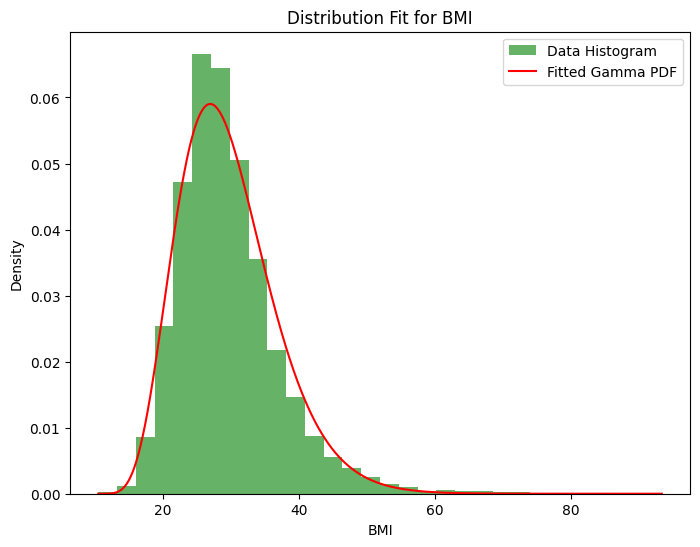

Column: gcs
{'type': 'continuous', 'best_fit': {'distribution': 'weibull_min', 'parameters': (38471244.38801053, -99790846.78306967, 99790859.80181998), 'ks_stat': 0.14331632536219463, 'p_value': 0.0}}


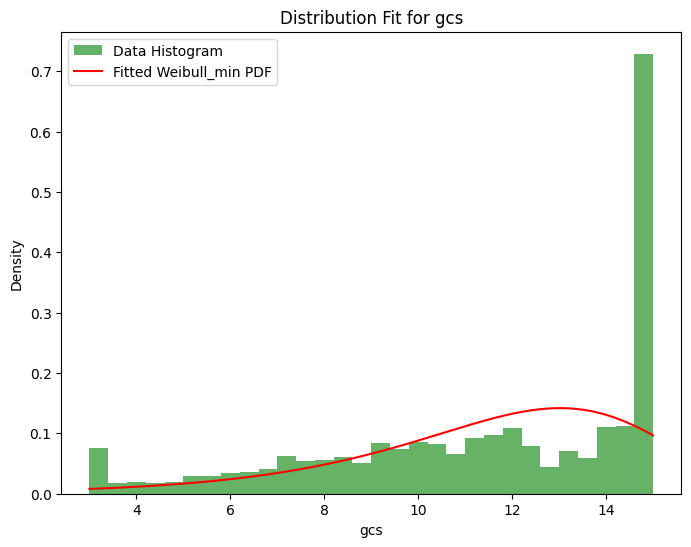

Column: crp_fdv
{'type': 'continuous', 'best_fit': {'distribution': 'beta', 'parameters': (0.6206738574295687, 5.7563062730943315, 0.09999999999999999, 816.163252713105), 'ks_stat': 0.08845430255134579, 'p_value': 0.0001737098012897183}}


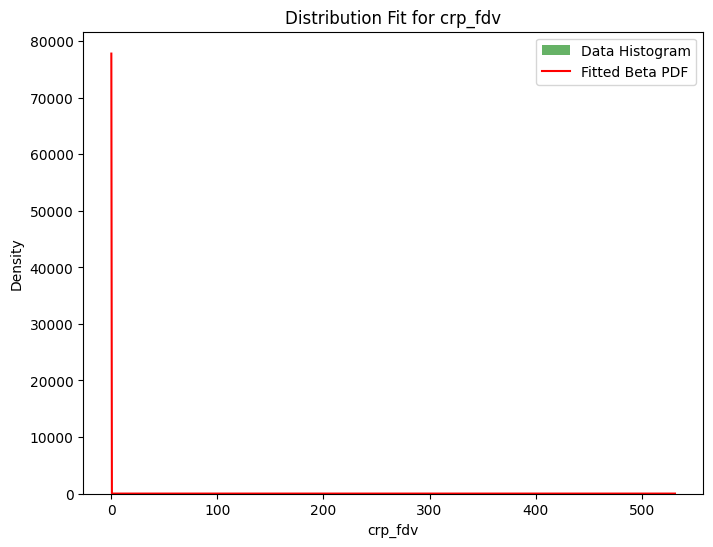

Column: wbc_fdv
{'type': 'continuous', 'best_fit': {'distribution': 't', 'parameters': (2.812886701084088, 11.736417657246845, 4.277865235386997), 'ks_stat': 0.052198644445318326, 'p_value': 1.2878225060987212e-58}}


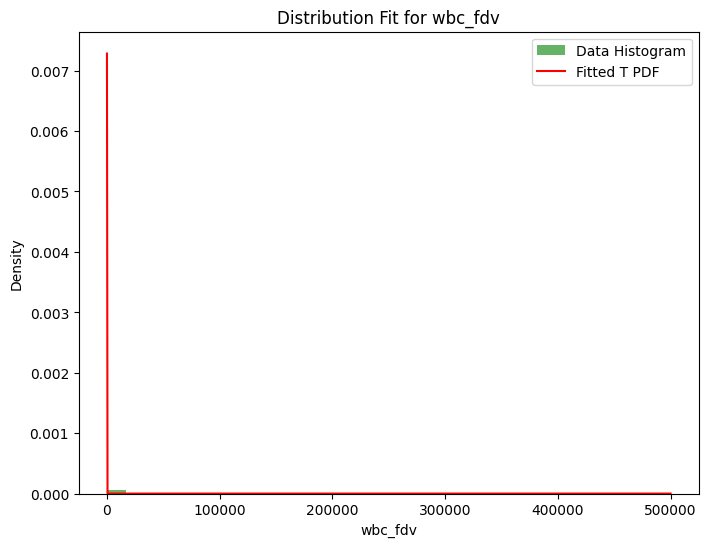

Column: heart_rate
{'type': 'continuous', 'best_fit': {'distribution': 'gamma', 'parameters': (28.13349200793565, 13.191068398343315, 2.7249278716757264), 'ks_stat': 0.022057211091050744, 'p_value': 7.906555492123958e-11}}


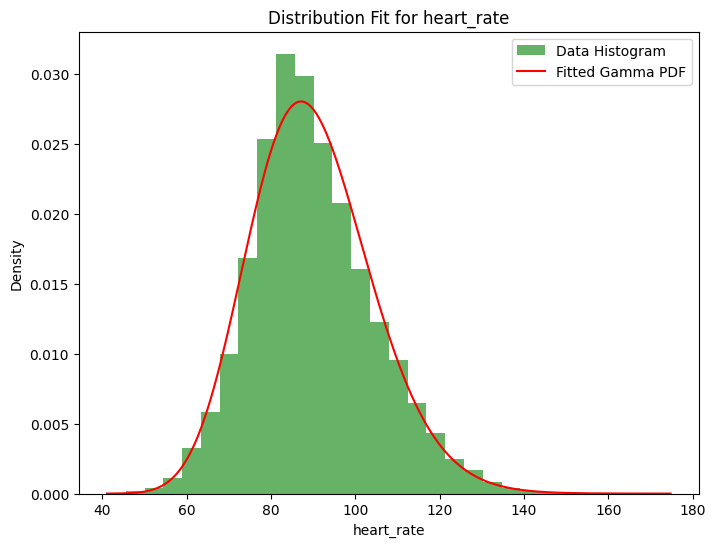

Column: sbp
{'type': 'continuous', 'best_fit': {'distribution': 'gamma', 'parameters': (11.34568759460084, 65.39993541339754, 4.537245792629008), 'ks_stat': 0.027431526903502035, 'p_value': 1.6338281565579113e-16}}


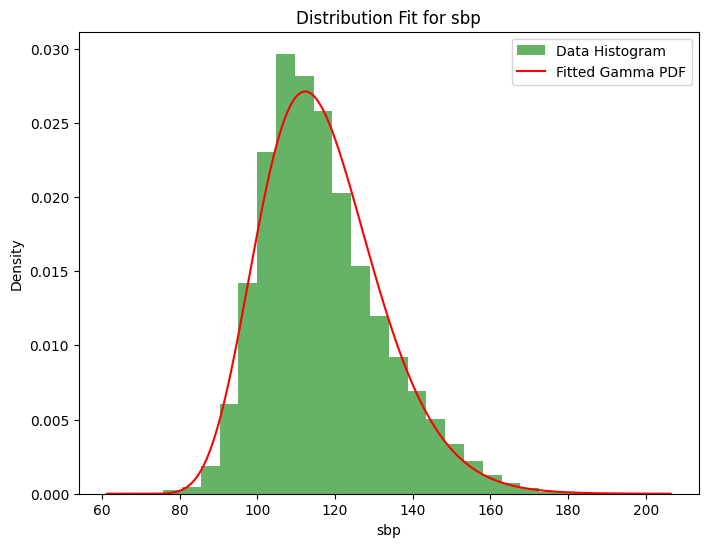

Column: dbp
{'type': 'continuous', 'best_fit': {'distribution': 'gamma', 'parameters': (14.993712266991182, 21.78564915174639, 2.744562125305279), 'ks_stat': 0.022142770482255547, 'p_value': 6.576462991446159e-11}}


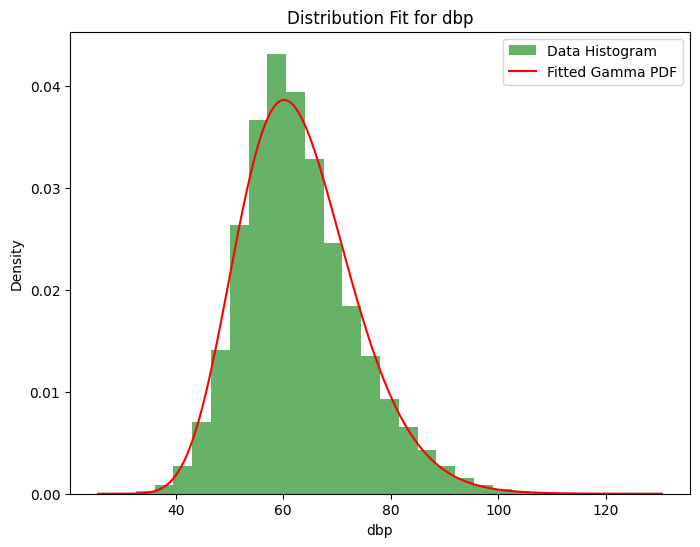

Column: body_temp
{'type': 'continuous', 'best_fit': {'distribution': 't', 'parameters': (4.982264867955433, 36.89358534177899, 0.4278321841501259), 'ks_stat': 0.03859340623009422, 'p_value': 1.1701684086250218e-29}}


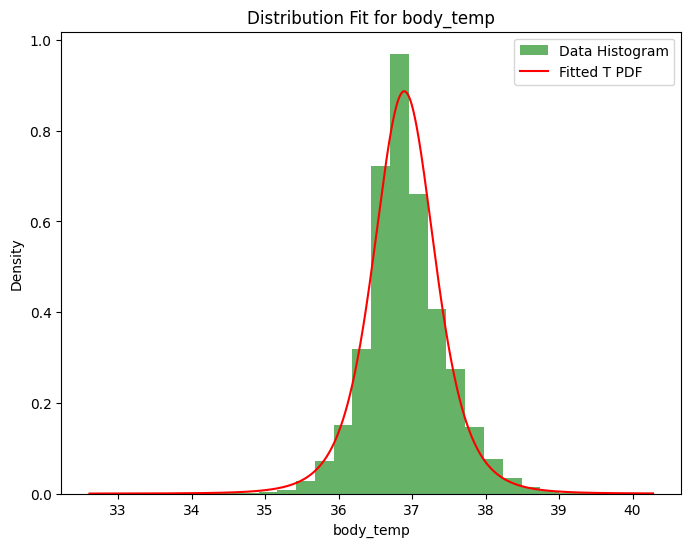

Column: spo2
{'type': 'continuous', 'best_fit': {'distribution': 'beta', 'parameters': (110.37209390728155, 2.138141692919256, -71.85663332934975, 172.09899735296858), 'ks_stat': 0.03892387182388457, 'p_value': 8.132010712990725e-33}}


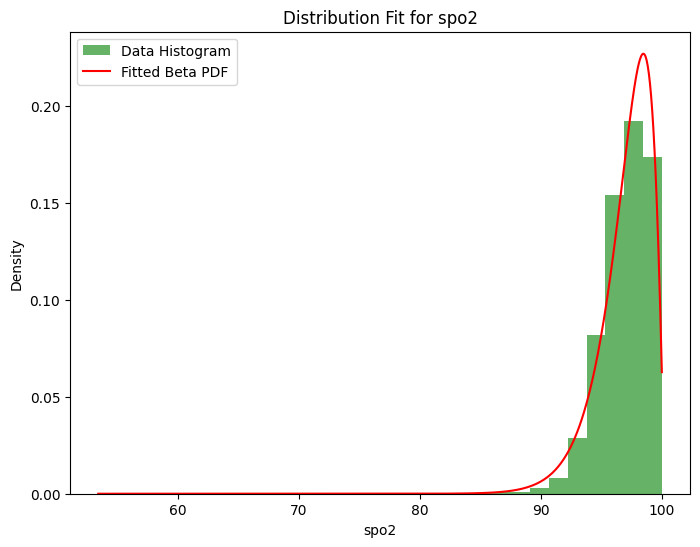

Column: resp_rate
{'type': 'continuous', 'best_fit': {'distribution': 'gamma', 'parameters': (10.528531502935625, 7.281101623561701, 1.1816171189948617), 'ks_stat': 0.03128500123673672, 'p_value': 2.372444765775839e-21}}


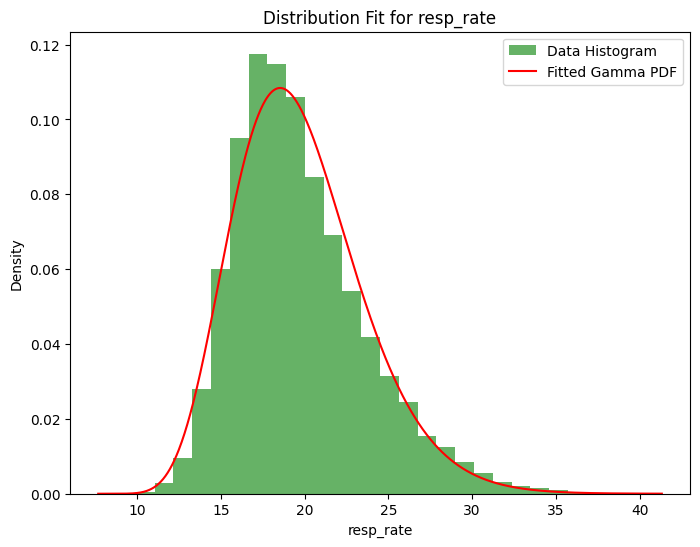

Column: fio2
{'type': 'continuous', 'best_fit': {'distribution': 'beta', 'parameters': (50.987554283881394, 20574958.483266104, -48.37689244881655, 41724538.13867759), 'ks_stat': 0.0737490869211998, 'p_value': 7.176128555240945e-80}}


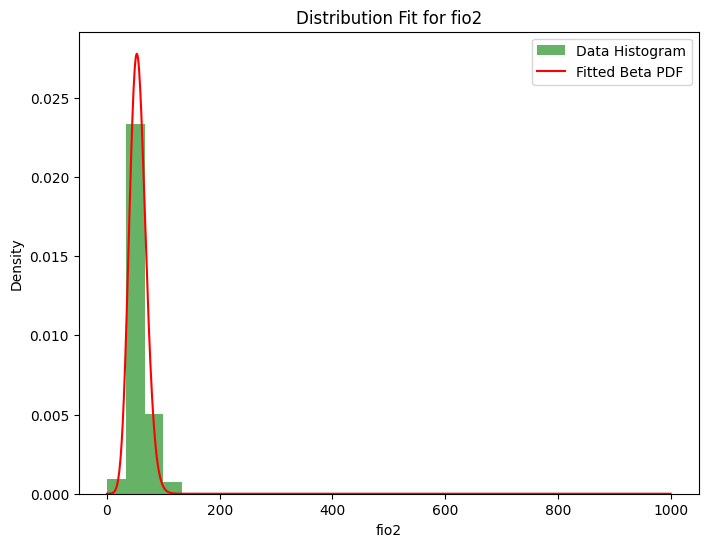

Column: albumin_bl_chem
{'type': 'continuous', 'best_fit': {'distribution': 'weibull_min', 'parameters': (3.9093558778586277, 0.8001205910873257, 2.5180857636578526), 'ks_stat': 0.03006131635014858, 'p_value': 4.2146189107586196e-07}}


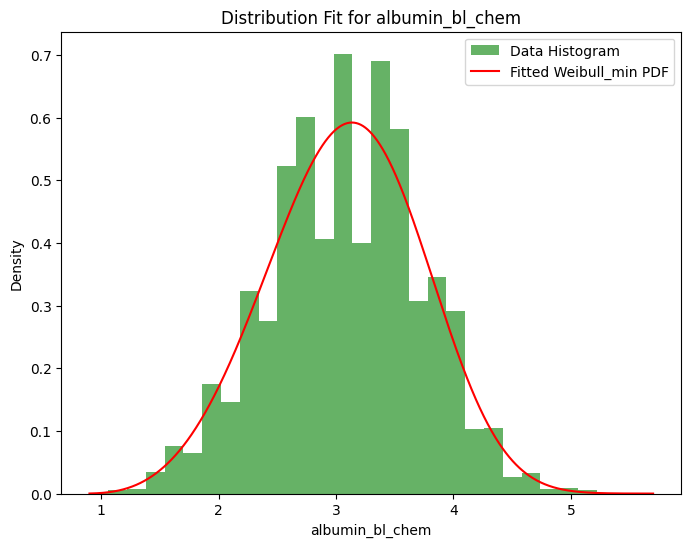

Column: aniongap
{'type': 'continuous', 'best_fit': {'distribution': 't', 'parameters': (4.859982095387537, 13.908112175409418, 2.9682261985296092), 'ks_stat': 0.05254222989646756, 'p_value': 2.180234590289249e-59}}


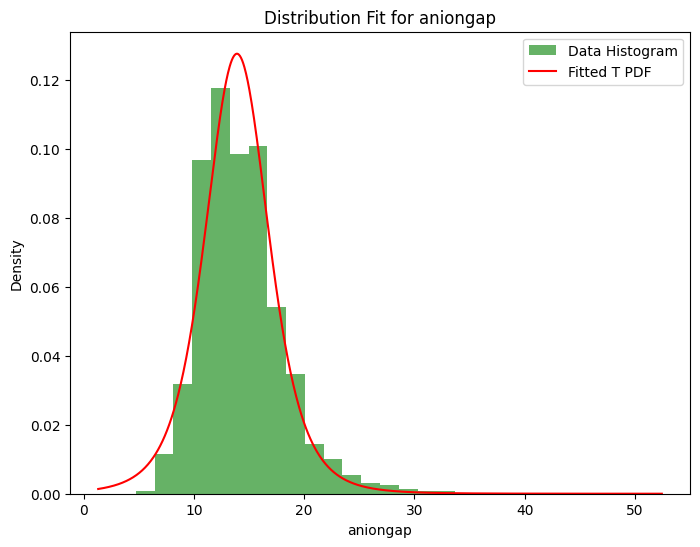

Column: bun
{'type': 'continuous', 'best_fit': {'distribution': 'beta', 'parameters': (2.1619122687801315, 5122.106697759183, 0.9966992113818376, 57523.07635104362), 'ks_stat': 0.09946133027896009, 'p_value': 3.1528510025018317e-212}}


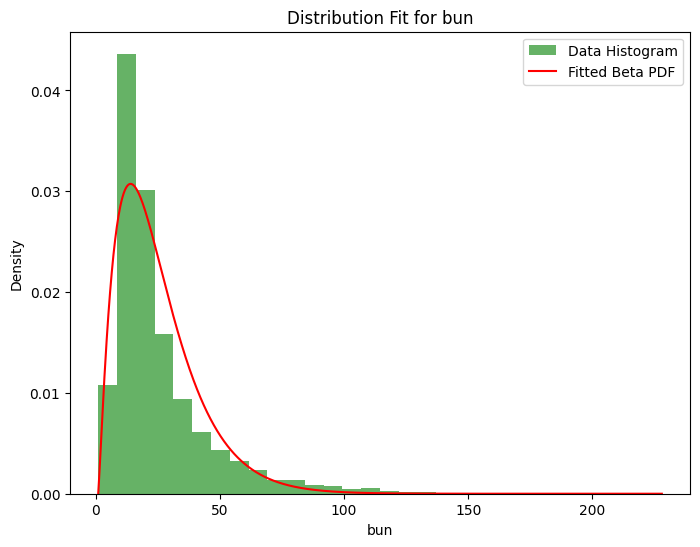

Column: calcium_chem
{'type': 'continuous', 'best_fit': {'distribution': 't', 'parameters': (6.32771290465546, 8.217206820663597, 0.6219446867552351), 'ks_stat': 0.023762685017050644, 'p_value': 2.3484941279190593e-11}}


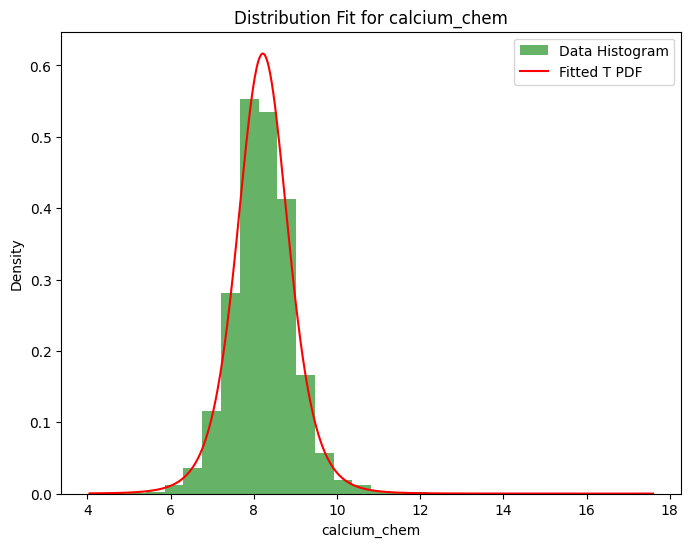

Column: chloride_chem
{'type': 'continuous', 'best_fit': {'distribution': 't', 'parameters': (5.236429280031512, 104.89645798922027, 4.835318776487446), 'ks_stat': 0.03552746971183579, 'p_value': 2.0743801401651876e-27}}


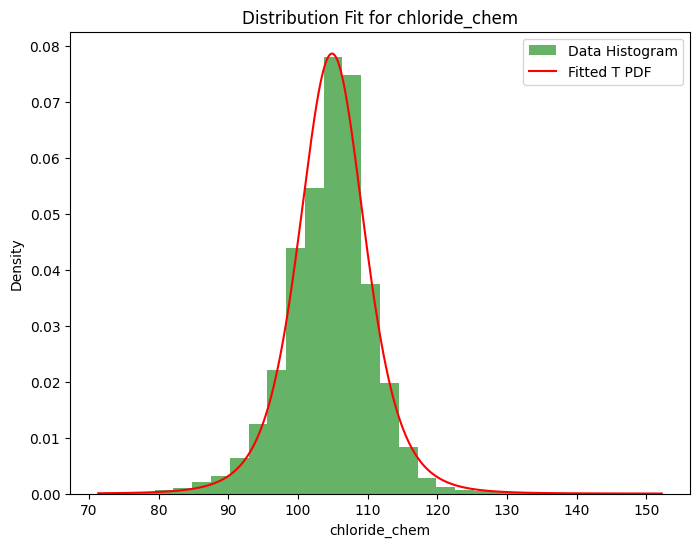

Column: creatinine_chem
{'type': 'continuous', 'best_fit': {'distribution': 't', 'parameters': (1.2023826650184943, 0.8989493939173434, 0.2885285923525239), 'ks_stat': 0.14820120171127343, 'p_value': 0.0}}


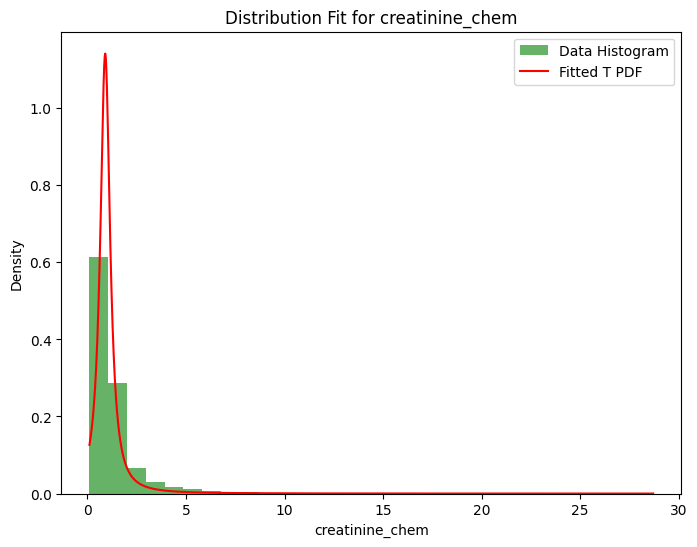

Column: glucose_chem
{'type': 'continuous', 'best_fit': {'distribution': 'gamma', 'parameters': (5.177827286404421, 33.79787166962224, 20.849855012658246), 'ks_stat': 0.07609597879057195, 'p_value': 1.024324596948268e-123}}


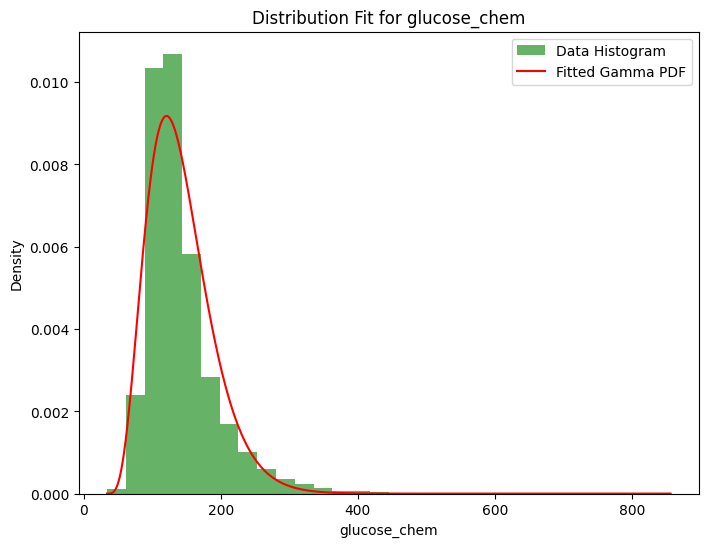

Column: sodium_chem
{'type': 'continuous', 'best_fit': {'distribution': 'normal', 'parameters': (138.44679827593217, 4.7550233114040115), 'ks_stat': 0.07901287980517166, 'p_value': 5.43136517993917e-134}}


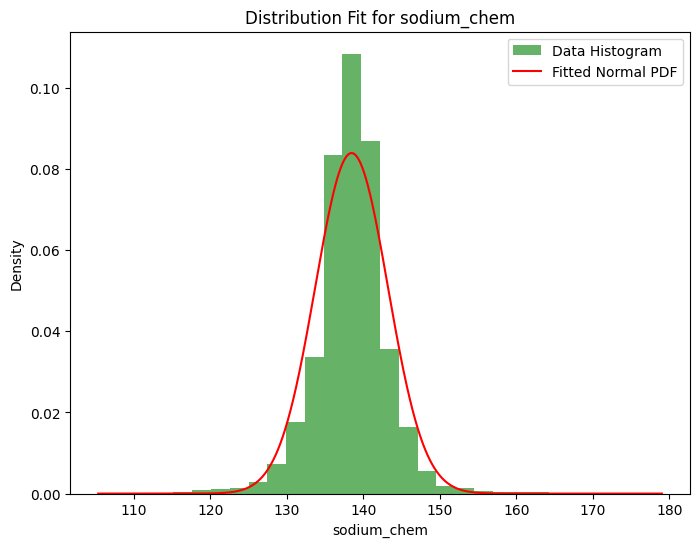

Column: potassium_chem
{'type': 'continuous', 'best_fit': {'distribution': 'beta', 'parameters': (16.12703469196172, 4735428.064960563, 1.933745673539163, 665731.9794554323), 'ks_stat': 0.037038591093132345, 'p_value': 9.994131409790918e-30}}


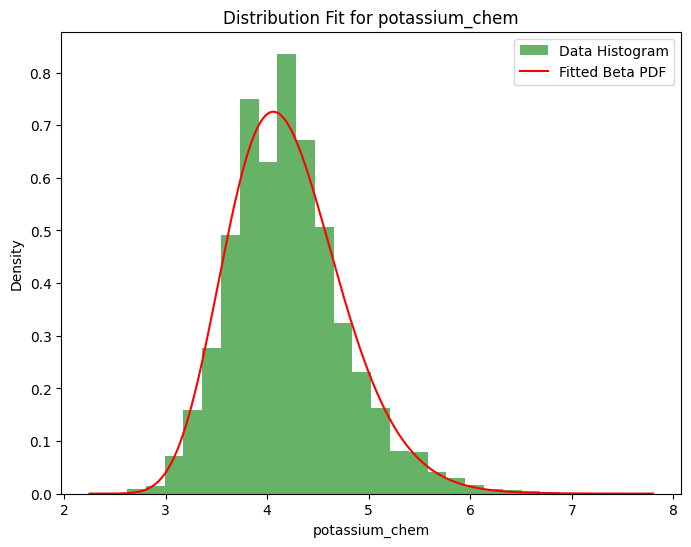

Column: magnesium_chem
{'type': 'continuous', 'best_fit': {'distribution': 't', 'parameters': (3.5441918307372497, 2.0165981438218594, 0.25226711467516555), 'ks_stat': 0.047422407224445254, 'p_value': 1.2061753279662935e-46}}


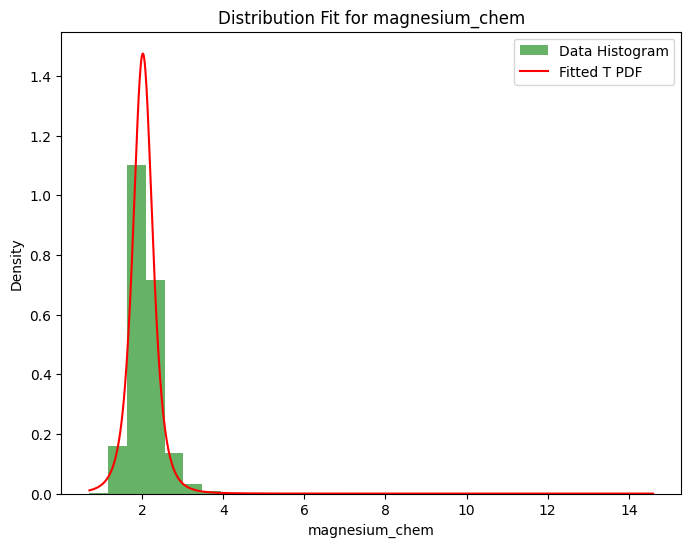

Column: lactate_813
{'type': 'continuous', 'best_fit': {'distribution': 'beta', 'parameters': (2.6817684040888263, 86445203993604.1, 0.29692239465563364, 61398395961519.72), 'ks_stat': 0.06725163194154682, 'p_value': 9.458956186447762e-75}}


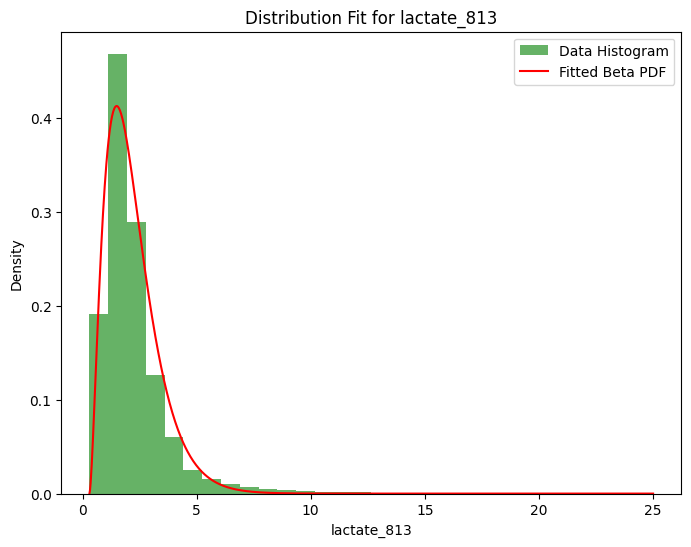

Column: bicarbonate
{'type': 'continuous', 'best_fit': {'distribution': 'gamma', 'parameters': (157.35728085871574, -31.75550774912446, 0.3468592824531047), 'ks_stat': 0.06525481327721411, 'p_value': 1.666326779272888e-91}}


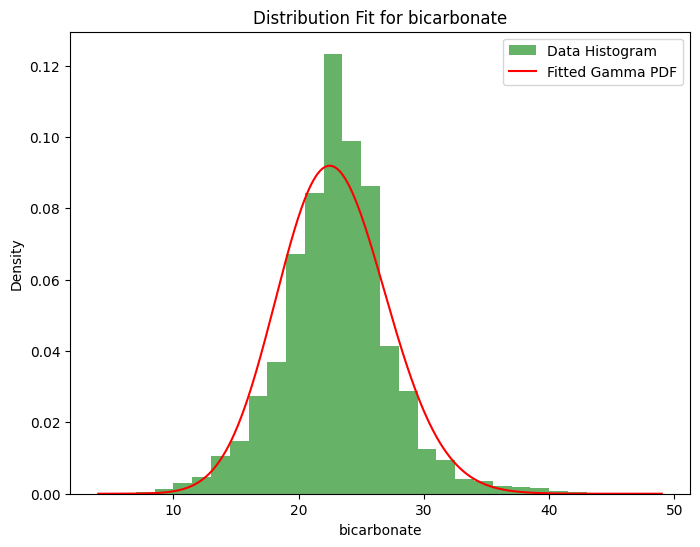

Column: ph
{'type': 'continuous', 'best_fit': {'distribution': 't', 'parameters': (6.0407606534496665, 7.373915044342654, 0.05799933679522806), 'ks_stat': 0.04805383189742879, 'p_value': 5.905485115425487e-41}}


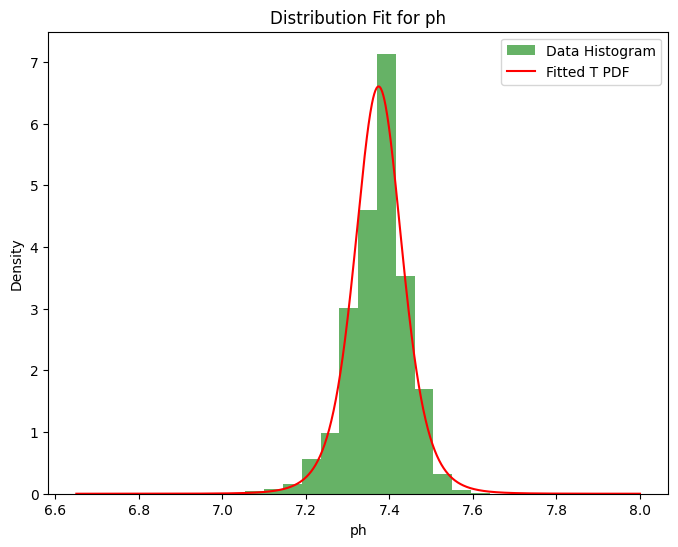

Column: po2_821
{'type': 'continuous', 'best_fit': {'distribution': 'beta', 'parameters': (1.9316821359011054, 10.502030309342814, 13.90784850224333, 794.3455836545747), 'ks_stat': 0.01932031019094982, 'p_value': 9.257487050952116e-07}}


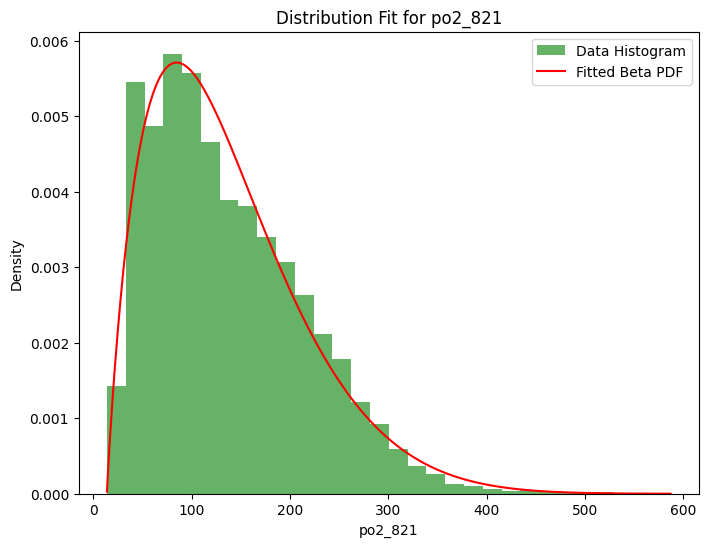

Column: pco2_818
{'type': 'continuous', 'best_fit': {'distribution': 'beta', 'parameters': (22.749885955596824, 1643694.4322708184, 1.2395699240418652, 2888539.9759294884), 'ks_stat': 0.07098982378313412, 'p_value': 5.5580119185369586e-86}}


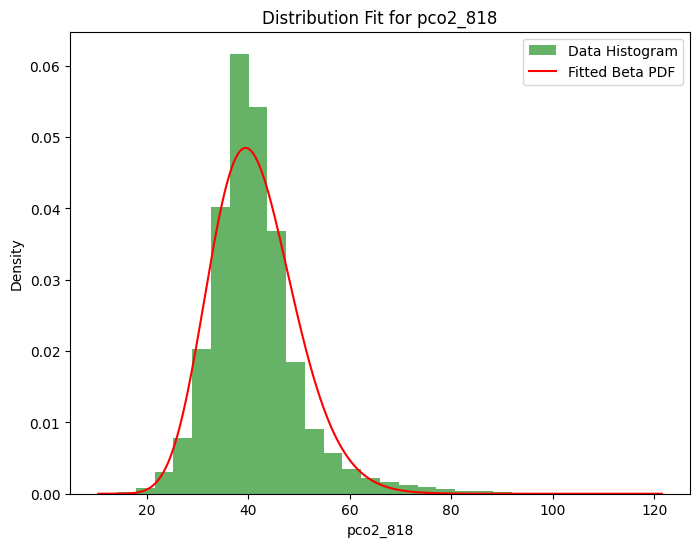

Column: hematocrit
{'type': 'continuous', 'best_fit': {'distribution': 'gamma', 'parameters': (15.849397363862819, 9.087462641926278, 1.4482425510155945), 'ks_stat': 0.014603811806822298, 'p_value': 5.534987886331111e-05}}


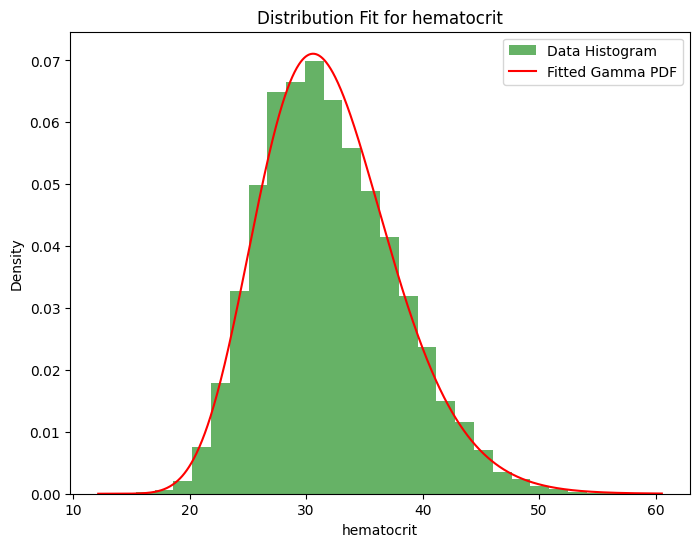

Column: hemoglobin
{'type': 'continuous', 'best_fit': {'distribution': 'beta', 'parameters': (11.700516040062318, 65.20810653626714, 3.235800345772468, 48.437260851498266), 'ks_stat': 0.015296995467341534, 'p_value': 2.008087518733053e-05}}


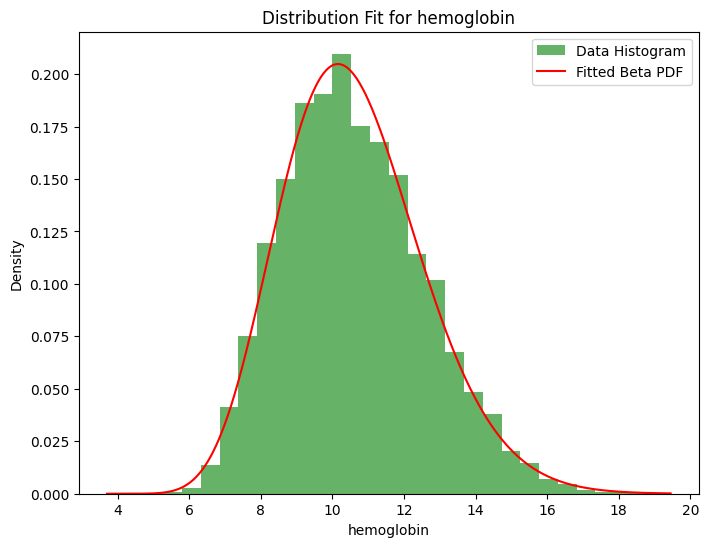

Column: platelet
{'type': 'continuous', 'best_fit': {'distribution': 'gamma', 'parameters': (4.5783503344512475, -15.164560242501853, 46.81988508874272), 'ks_stat': 0.03156710498343873, 'p_value': 1.0458801178160727e-21}}


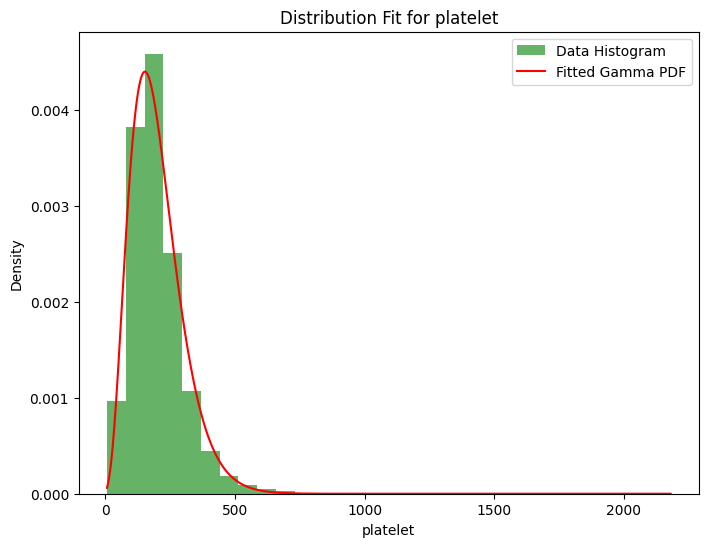

Column: NeuC
{'type': 'continuous', 'best_fit': {'distribution': 'beta', 'parameters': (416589390.7713136, 3.0556042365574174, -3008135170.059499, 3008135270.1419325), 'ks_stat': 0.04966768006803279, 'p_value': 5.110792855096744e-26}}


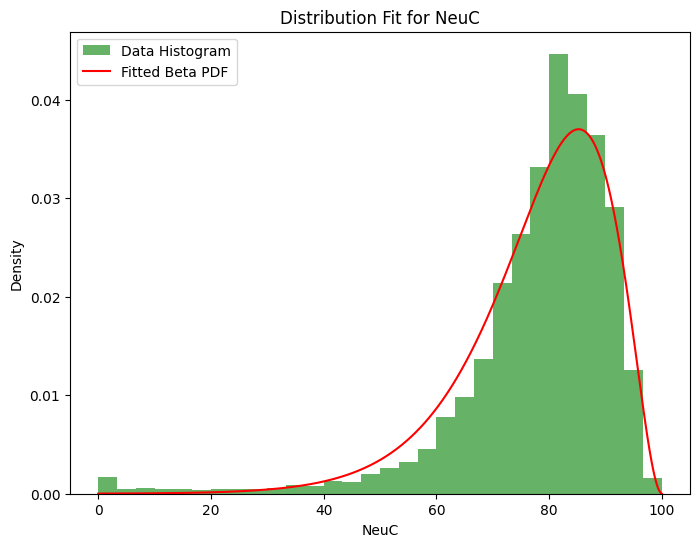

Column: EoC
{'type': 'continuous', 'best_fit': {'distribution': 'rayleigh', 'parameters': (-1.357887694394733, 2.0676014314167737), 'ks_stat': 0.2520098159727535, 'p_value': 0.0}}


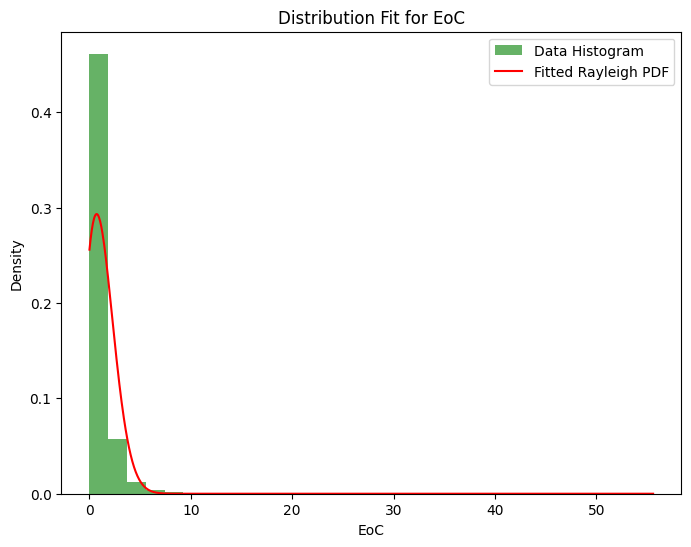

Column: LymC
{'type': 'continuous', 'best_fit': {'distribution': 'gamma', 'parameters': (1.802635995270382, -0.22441807612392112, 7.286001926275503), 'ks_stat': 0.025080539654849313, 'p_value': 5.945908845170155e-07}}


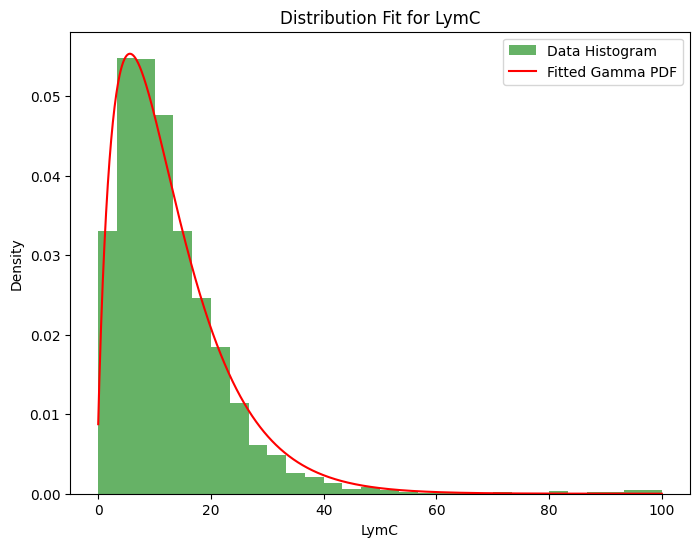

Column: nl_ratio
{'type': 'continuous', 'best_fit': {'distribution': 'weibull_min', 'parameters': (1.0204034055987783, -0.0007721657672225942, 12.614670822967975), 'ks_stat': 0.08775322223028054, 'p_value': 8.582141609483349e-80}}


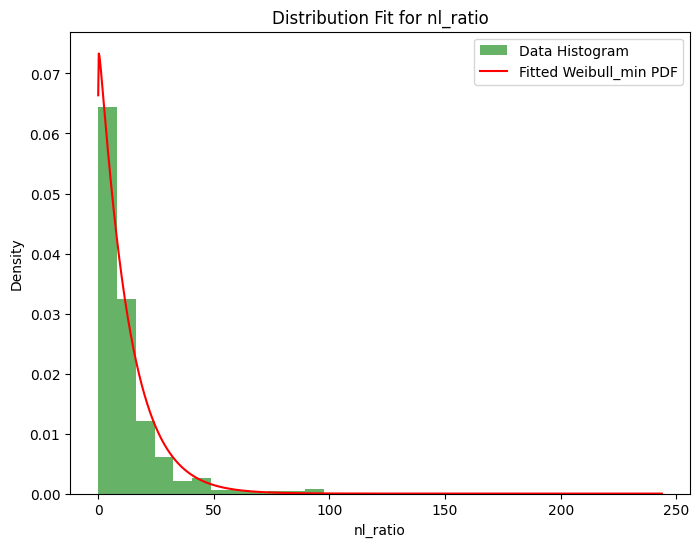

Column: age
{'type': 'continuous', 'best_fit': {'distribution': 'beta', 'parameters': (8.039319954291793, 3.0748903311728255, -28.799867654278316, 128.93460160247116), 'ks_stat': 0.021844494447261303, 'p_value': 1.2520767387288748e-10}}


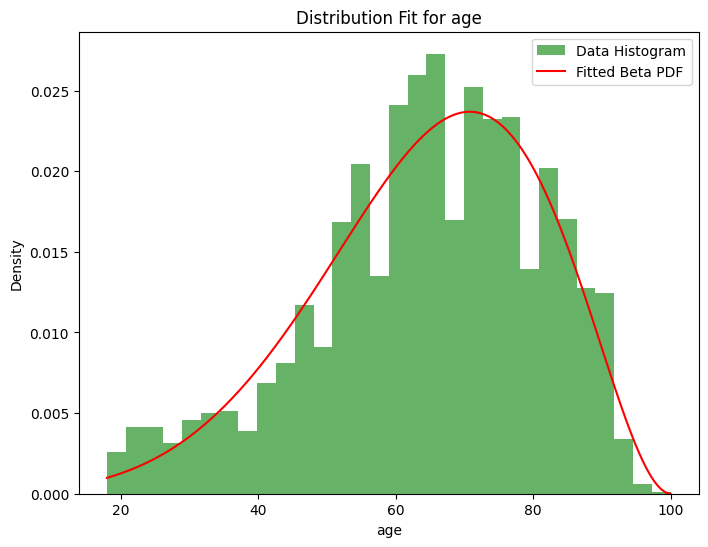

Column: sirs_score
{'type': 'continuous', 'best_fit': {'distribution': 'beta', 'parameters': (0.019878054773596294, 0.04545507419980978, 1.9999999999999998, 2.3108116194555084), 'ks_stat': 0.37626315662814236, 'p_value': 0.0}}


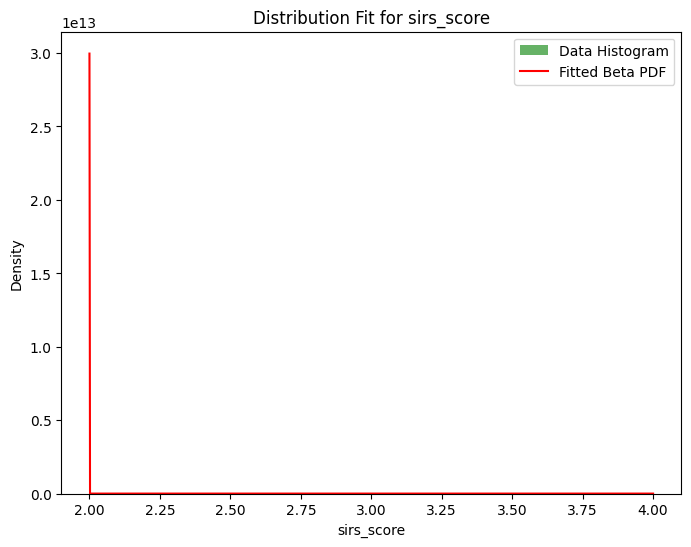

Column: sofa_score
{'type': 'continuous', 'best_fit': {'distribution': 'beta', 'parameters': (7.172370668033814, 12.044679850329327, -1.4029940639195981, 10.182409833696841), 'ks_stat': 0.18896546869359176, 'p_value': 0.0}}


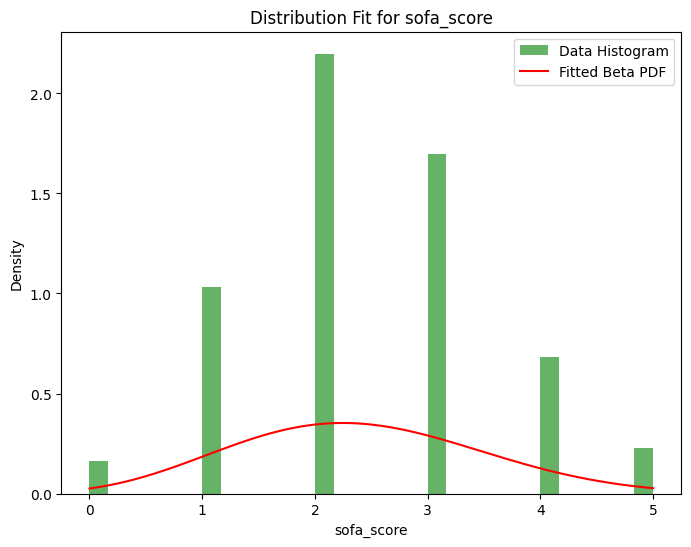

Column: oasis
{'type': 'continuous', 'best_fit': {'distribution': 'weibull_min', 'parameters': (2.4353964856730776, 7.763306882726919, 20.699957161666653), 'ks_stat': 0.04592592480704971, 'p_value': 1.5823438964725508e-45}}


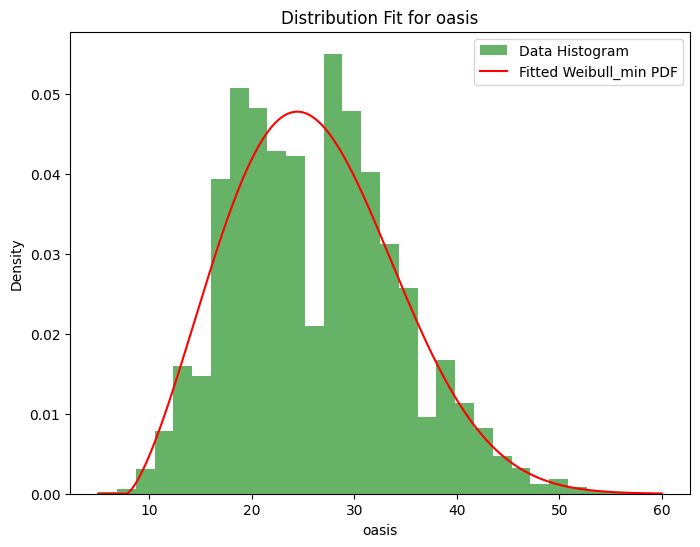

In [32]:
# Define columns by type
columns_by_type = {
    "categorical": [ ],
    "binary": [
        "d48h", "d90d", "dinhosp", "mechvent", "vasopressor", "diagnosis",
        "gender", "renal_replacement", "mild_liver_disease", "severe_liver_disease",
        "diabetes_with_cc", "diabetes_without_cc", "hypertension", "copd"
    ],
    "integr": ["age", "sirs_score", "sofa_score", "oasis"],
    "continuous": [
        "BMI", "gcs", "crp_fdv", "wbc_fdv", "heart_rate", "sbp", "dbp",
        "body_temp", "spo2", "resp_rate", "fio2", "albumin_bl_chem", "aniongap",
        "bun", "calcium_chem", "chloride_chem", "creatinine_chem", "glucose_chem",
        "sodium_chem", "potassium_chem", "magnesium_chem", "lactate_813",
        "bicarbonate", "ph", "po2_821", "pco2_818", "hematocrit", "hemoglobin",
        "platelet", "NeuC", "EoC", "LymC", "nl_ratio"
    ]
}

# Call the distribution fitting function on continuous and integral columns only.
fit_results_extended = fit_and_test_distributions(
    X,
    continuous_cols=columns_by_type["continuous"] + columns_by_type["integr"]
)

# Loop through the fitted results.
# For each column, print the result and plot the distribution fit only if:
#   - The column is not binary (i.e. has more than 2 unique non-null values)
#   - A best-fit distribution was successfully found.

for col, result in fit_results_extended.items():
    print(f"Column: {col}")
    print(result)
    # Check whether the column is binary (or nearly so)
    if X[col].dropna().nunique() <= 2:
        print(f"Skipping distribution plotting for binary column: {col}")
        continue

    # Only attempt to plot if a best fit exists.
    if result.get('best_fit') is not None:
        plot_distribution_fit(X[col], result['best_fit'], col)
    else:
        print(f"No valid best-fit found for column: {col}")


### statistical_analysis_for_groups

Overall MCAR and MNAR Analysis:


<Figure size 1000x600 with 0 Axes>

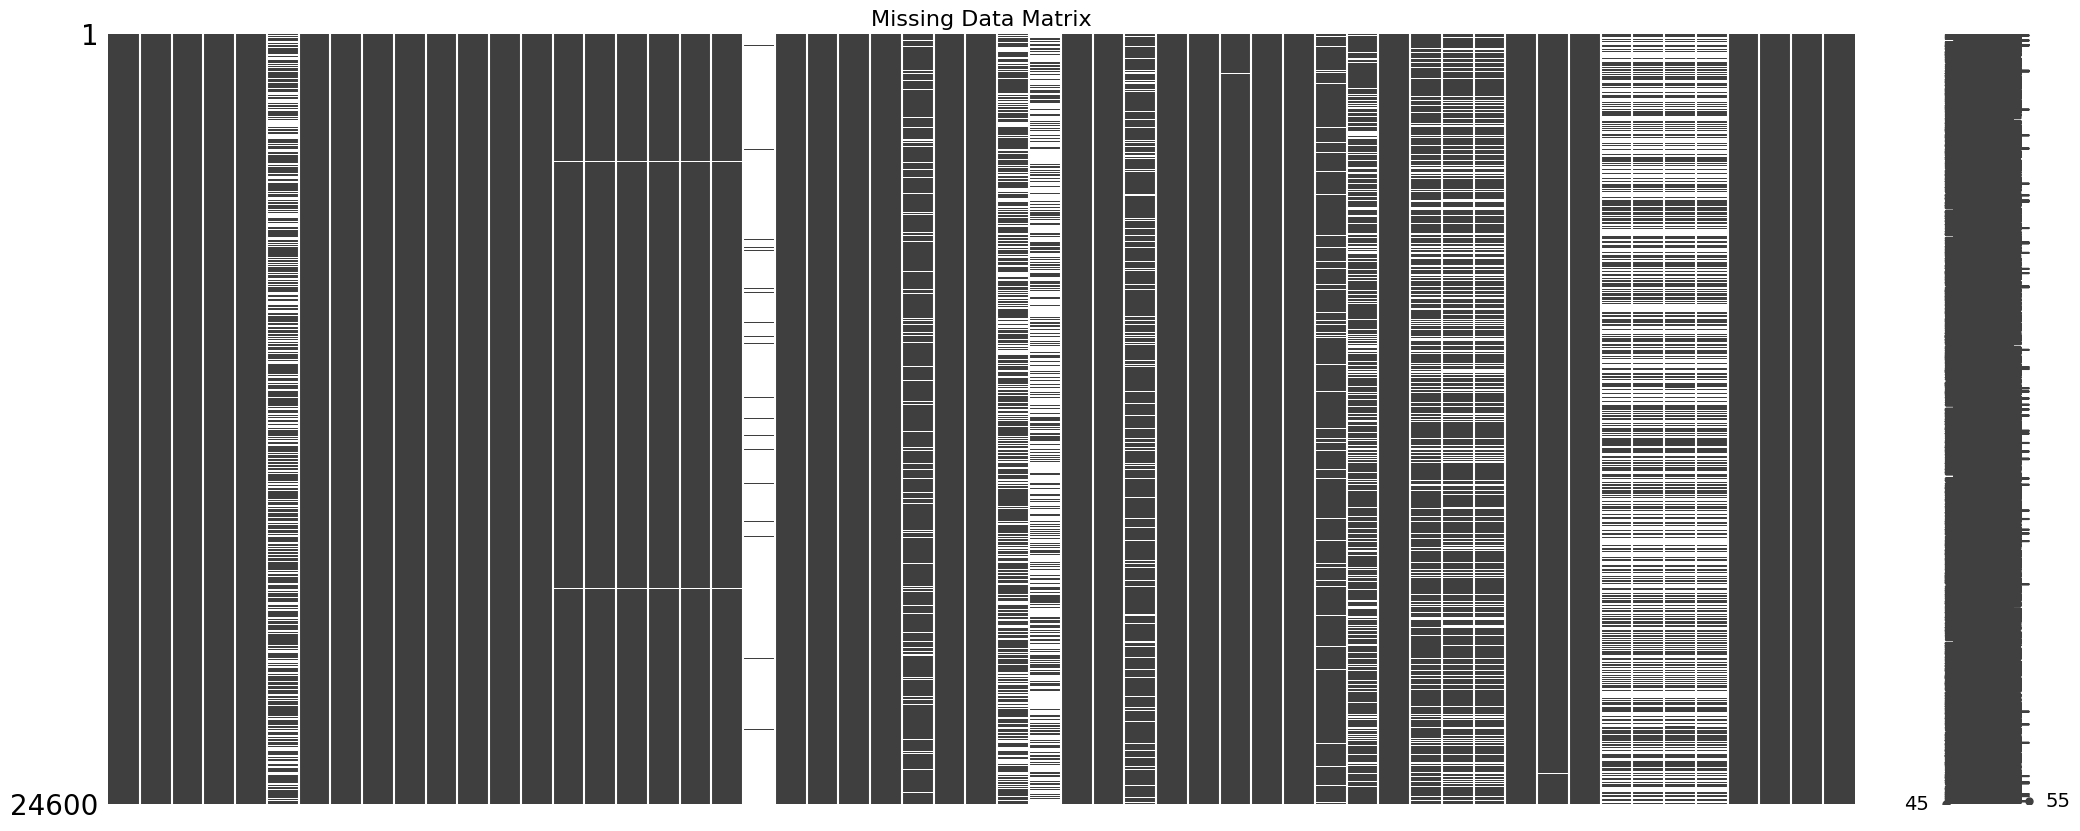

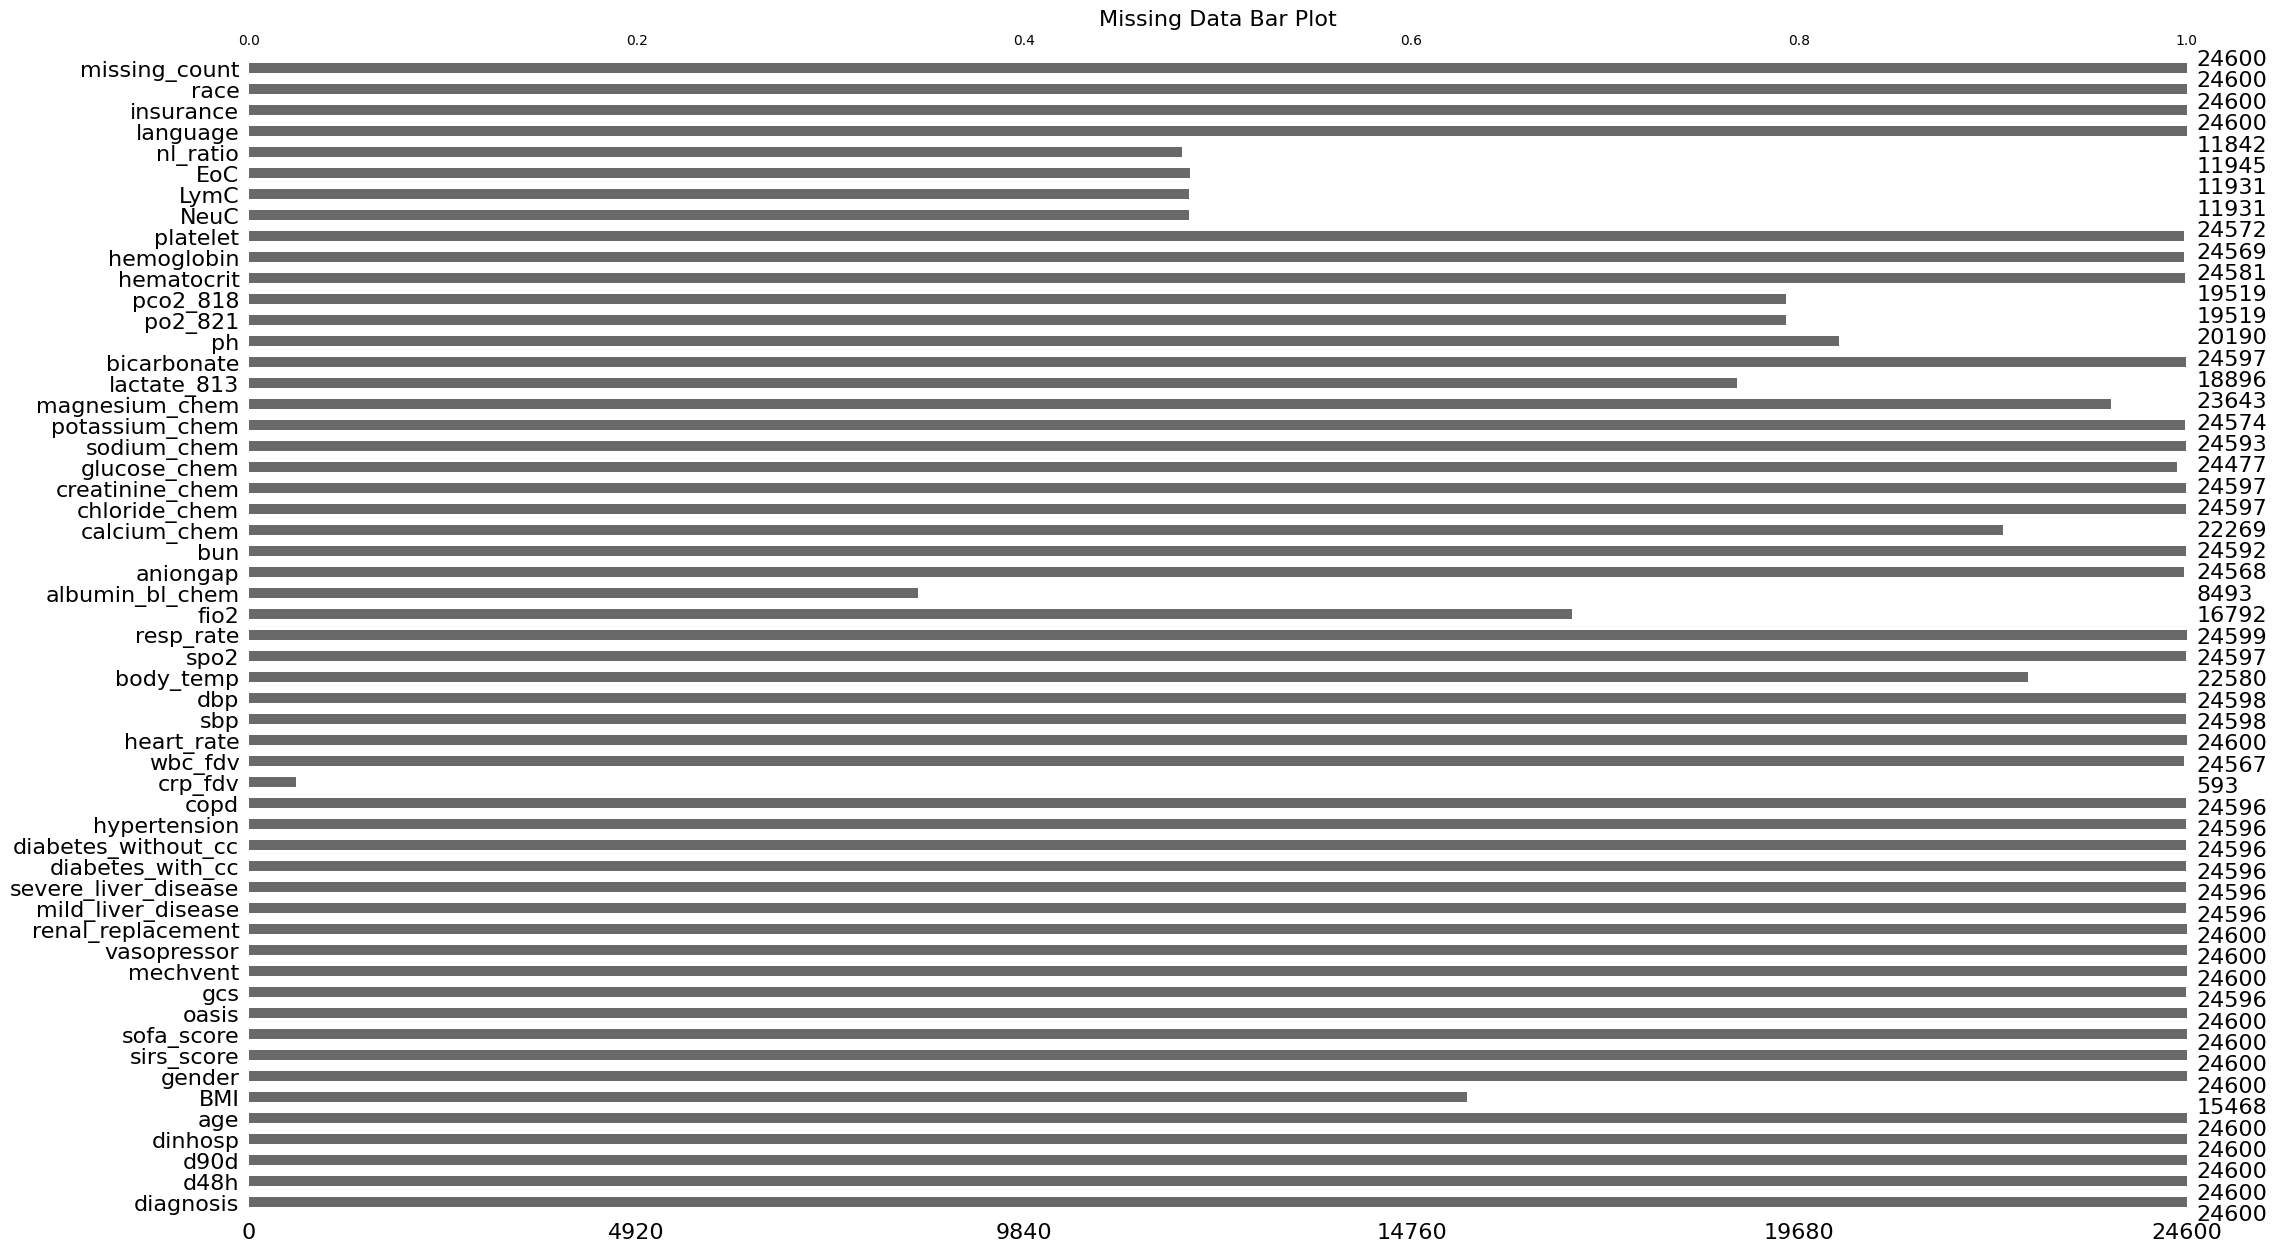

<Figure size 1000x600 with 0 Axes>

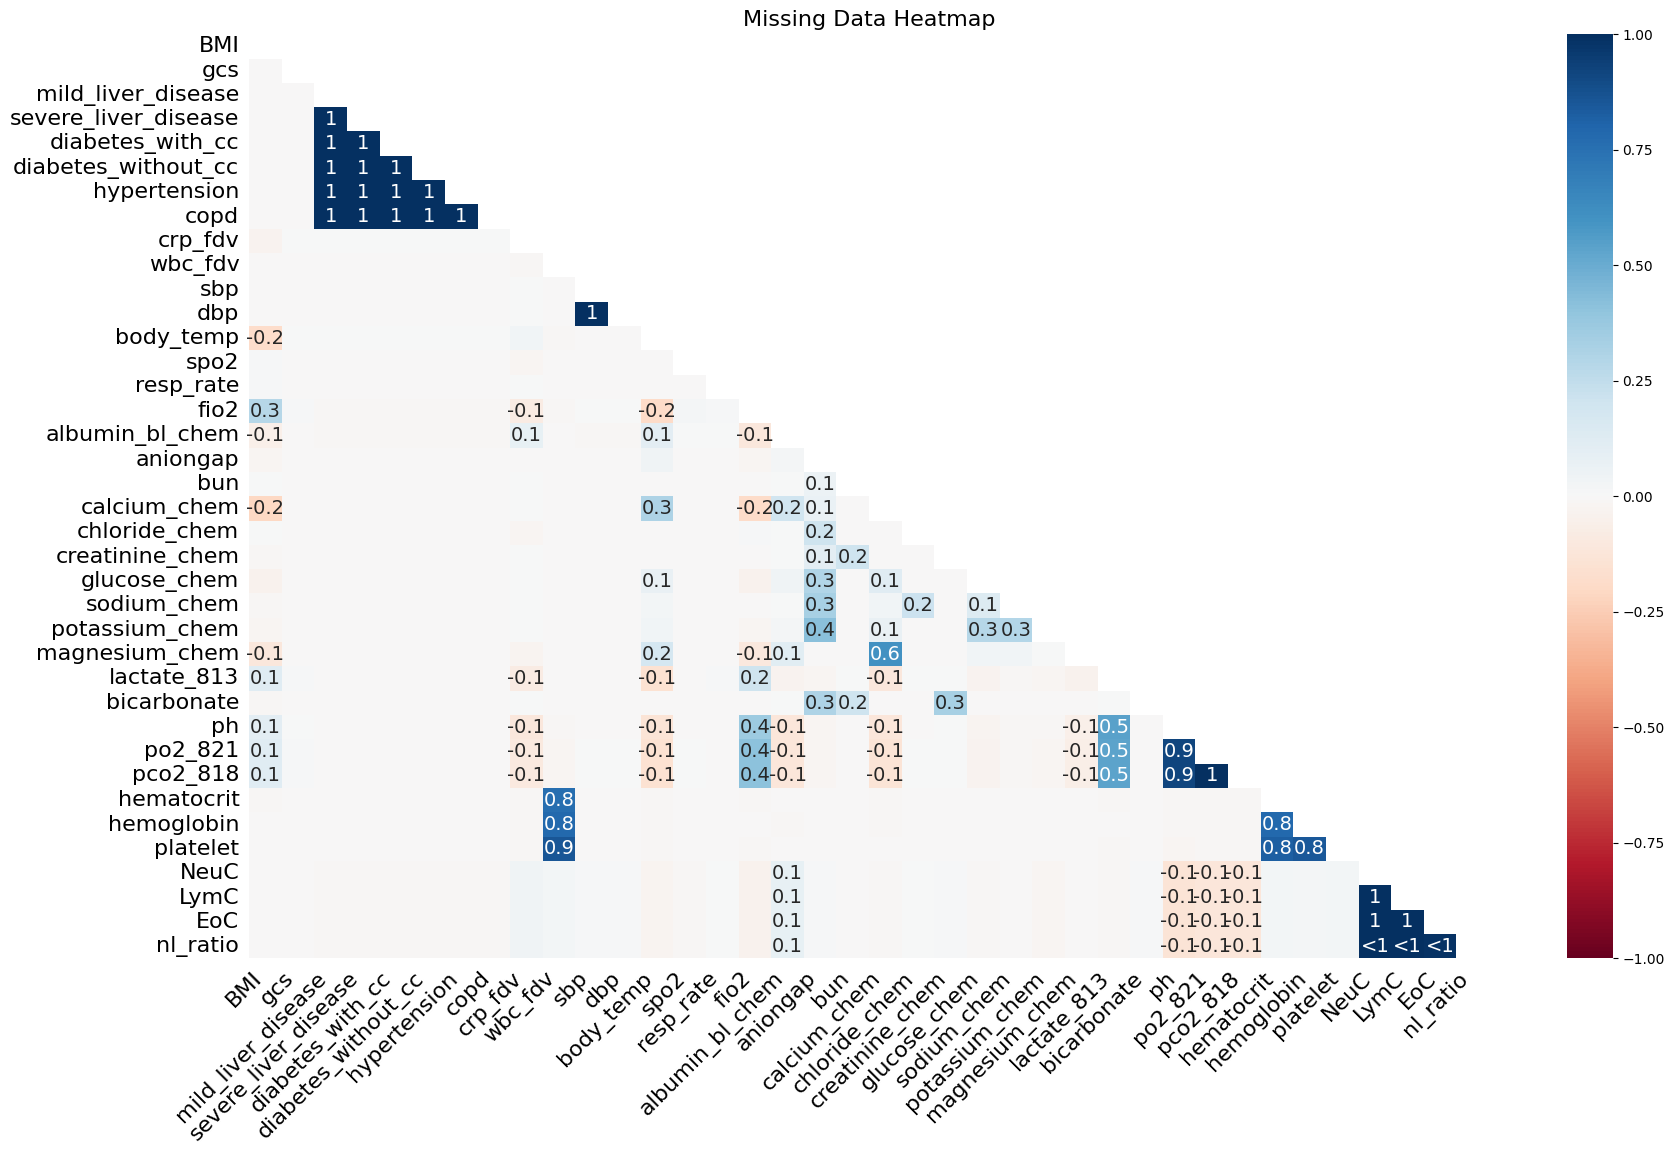

<Figure size 1000x600 with 0 Axes>

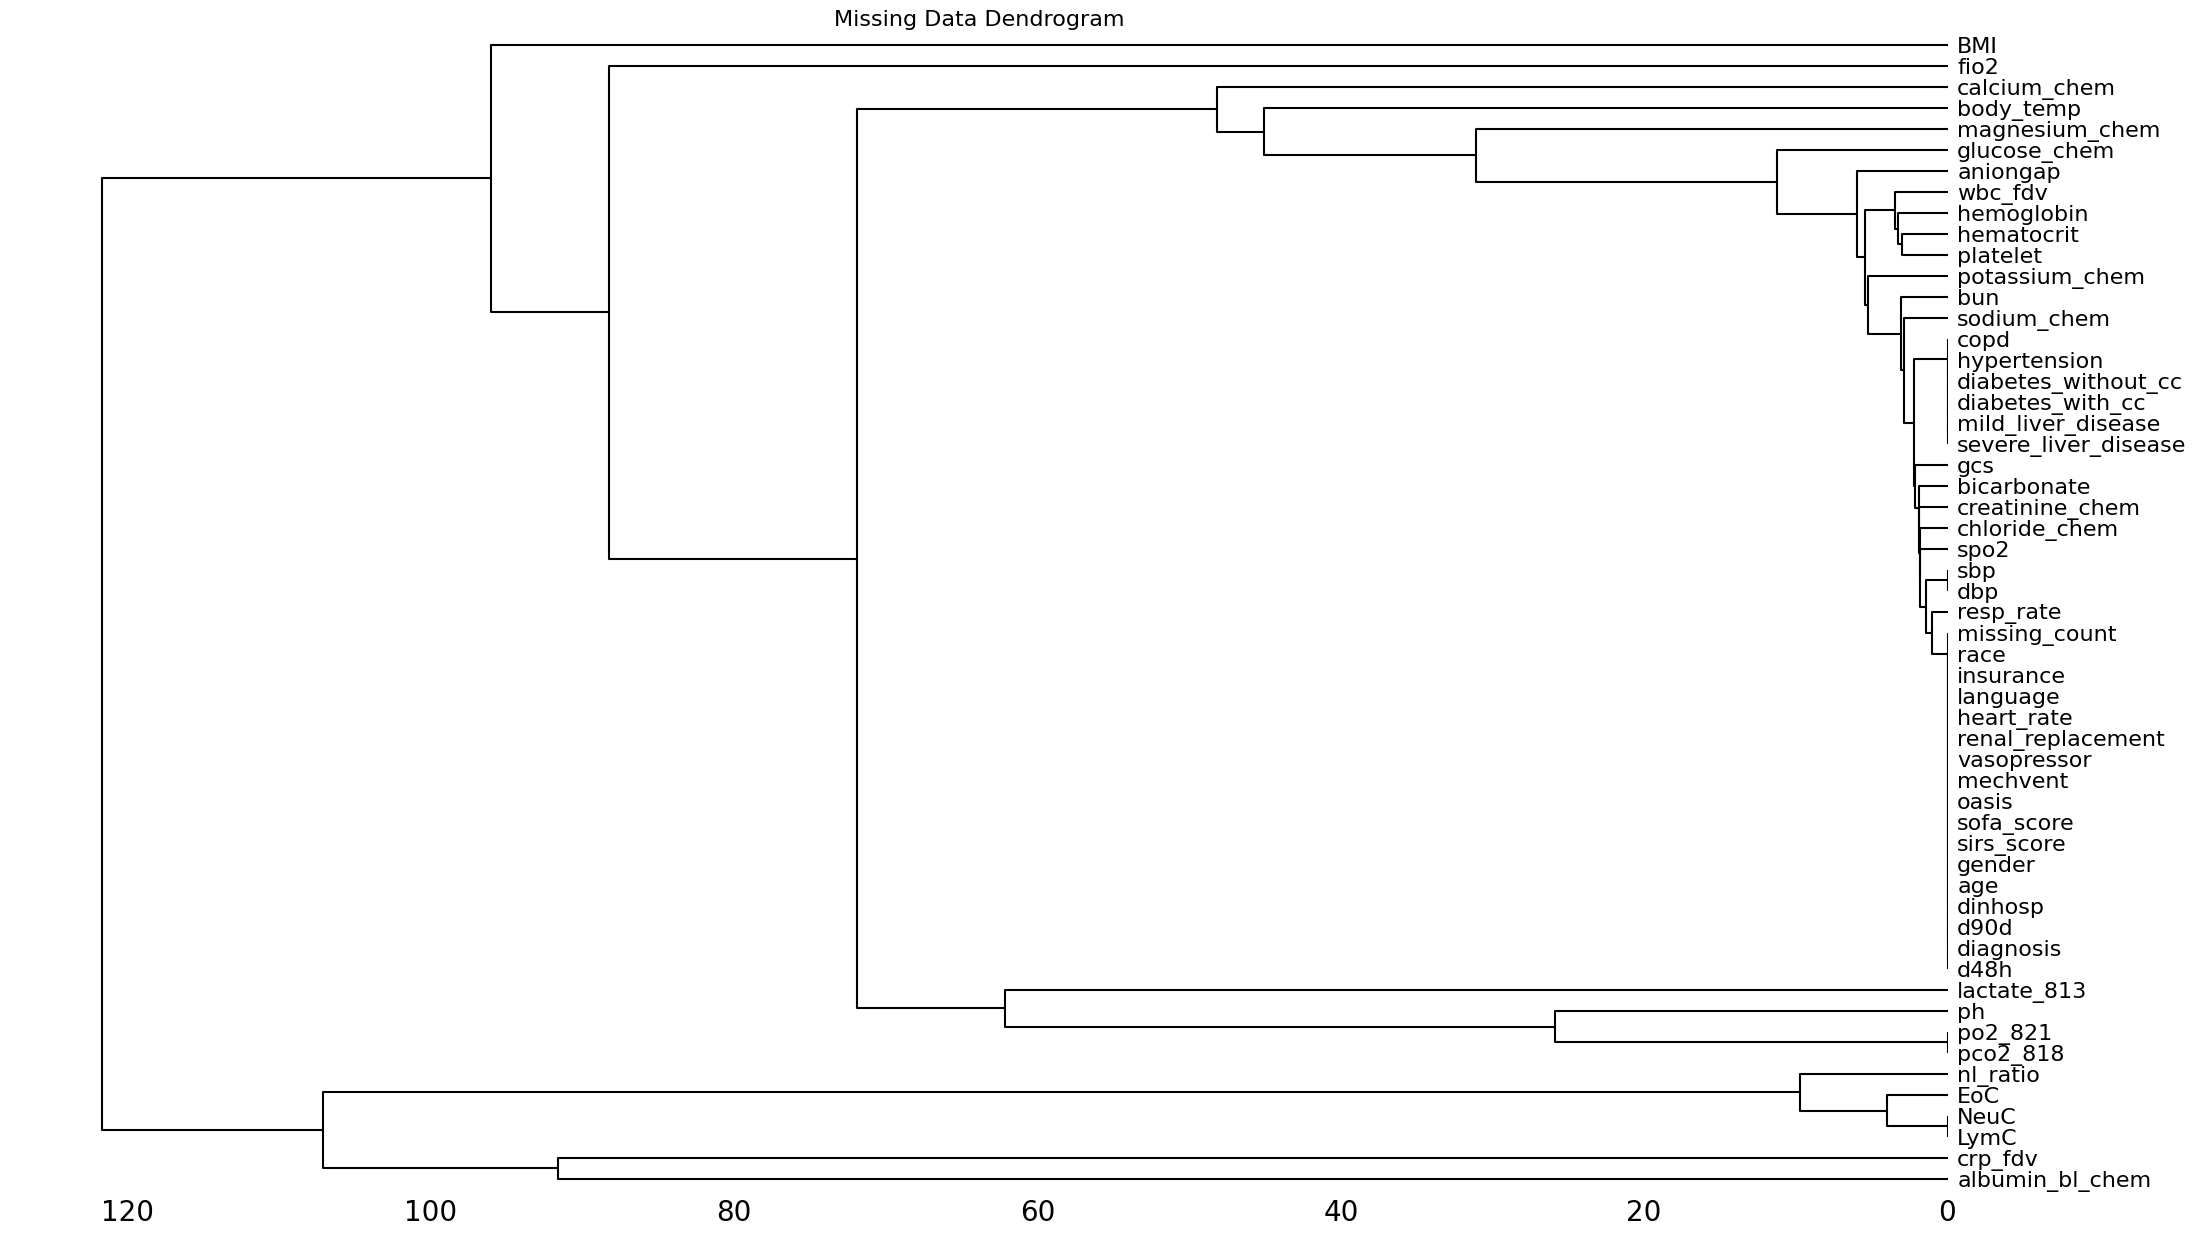

Missing Values Analysis by Demographics:
    gender  race  language  insurance  Average Missing Count
23       1     2         0          2               5.906336
6        0     2         0          0               5.850485
8        0     2         0          2               5.746725
25       1     3         0          1               5.706897
3        0     1         0          0               5.690323
14       0     4         0          2               5.676387
19       1     1         0          1               5.664000
12       0     4         0          0               5.651249
11       0     3         0          2               5.635294
21       1     2         0          0               5.630037
5        0     1         0          2               5.621359
18       1     1         0          0               5.621212
7        0     2         0          1               5.586667
20       1     1         0          2               5.543046
4        0     1         0          1       

In [33]:
demographics = ['gender', 'race', 'language', 'insurance']

print("Overall MCAR and MNAR Analysis:")
try:
    mcar_p_value, missing_analysis = test_mcar_with_visualization(Z, demographics, plot=True)
    print("Missing Values Analysis by Demographics:")
    print(missing_analysis)
    print(f"MCAR Test P-Value: {mcar_p_value}")
    if mcar_p_value < 0.05:
        print("Missing data is NOT MCAR (could be MAR or MNAR).")
    else:
        print("Missing data is MCAR.")
except ValueError as e:
    print(f"Error during MCAR test: {e}")

mnar_results = test_mnar(Z)
print("\nMNAR Test Results (Overall):")
for col, res in mnar_results.items():
    print(f"{col}: {res}")

insurance_categories = {
    3: "Private",
    2: "Medicare",
    1: "Medicaid",
    0: "No pay/Other"
}

print("\nPer-Insurance MCAR and MNAR Analysis:")
for ins_val, ins_name in insurance_categories.items():
    subset = Z[Z['insurance'] == ins_val]
    if subset.empty:
        print(f"{ins_name} (code={ins_val}): No data available for MCAR/MNAR tests.")
        continue

    print(f"\nInsurance: {ins_name} (code={ins_val})")
    try:
        mcar_p_value_ins, missing_analysis_ins = test_mcar_with_visualization(subset, demographics, plot=False)
        print("Missing Values Analysis by Demographics (subset):")
        print(missing_analysis_ins)
        print(f"MCAR Test P-Value: {mcar_p_value_ins}")
        if mcar_p_value_ins < 0.05:
            print("Missing data is NOT MCAR (could be MAR or MNAR) for this insurance category.")
        else:
            print("Missing data is MCAR for this insurance category.")
    except ValueError as e:
        print(f"Error during MCAR test for {ins_name}: {e}")

    mnar_results_ins = test_mnar(subset)
    print("MNAR Test Results (subset):")
    for col, res in mnar_results_ins.items():
        print(f"{col}: {res}")

Z_bias_tables_by_insurance = compute_demographic_percentages_multi(Z, missing_threshold=10)

for ins_name, df in Z_bias_tables_by_insurance.items():
    print(f"\nDemographic Percentages with Missing Counts > 10 for Insurance: {ins_name}")
    print(df)

print("\nComparing survival rates across insurance types:")
for ins_val, ins_name in insurance_categories.items():
    subset = Z[Z['insurance'] == ins_val]
    if len(subset) > 0:
        survival_48h = 1 - subset['d48h'].mean()
        survival_90d = 1 - subset['d90d'].mean()
        survival_inhosp = 1 - subset['dinhosp'].mean()

        print(f"Insurance: {ins_name} (code={ins_val})")
        print(f"  48h Survival: {survival_48h:.2f}")
        print(f"  90d Survival: {survival_90d:.2f}")
        print(f"  In-Hospital Survival: {survival_inhosp:.2f}")
    else:
        print(f"Insurance: {ins_name} (code={ins_val}) - No records found.\n")

print("\nComparing survival rates across race types:")
for ins_val, ins_name in insurance_categories.items():
    subset = Z[Z['race'] == ins_val]
    if len(subset) > 0:
        survival_48h = 1 - subset['d48h'].mean()
        survival_90d = 1 - subset['d90d'].mean()
        survival_inhosp = 1 - subset['dinhosp'].mean()

        print(f"Race: {ins_name} (code={ins_val})")
        print(f"  48h Survival: {survival_48h:.2f}")
        print(f"  90d Survival: {survival_90d:.2f}")
        print(f"  In-Hospital Survival: {survival_inhosp:.2f}")
    else:
        print(f"Race: {ins_name} (code={ins_val}) - No records found.\n")

print("\nComparing survival rates across language types:")
for ins_val, ins_name in insurance_categories.items():
    subset = Z[Z['language'] == ins_val]
    if len(subset) > 0:
        survival_48h = 1 - subset['d48h'].mean()
        survival_90d = 1 - subset['d90d'].mean()
        survival_inhosp = 1 - subset['dinhosp'].mean()

        print(f"Language: {ins_name} (code={ins_val})")
        print(f"  48h Survival: {survival_48h:.2f}")
        print(f"  90d Survival: {survival_90d:.2f}")
        print(f"  In-Hospital Survival: {survival_inhosp:.2f}")
    else:
        print(f"Language: {ins_name} (code={ins_val}) - No records found.\n")

print("\nComparing survival rates across language types:")
for ins_val, ins_name in insurance_categories.items():
    subset = Z[Z['gender'] == ins_val]
    if len(subset) > 0:
        survival_48h = 1 - subset['d48h'].mean()
        survival_90d = 1 - subset['d90d'].mean()
        survival_inhosp = 1 - subset['dinhosp'].mean()

        print(f"Gender: {ins_name} (code={ins_val})")
        print(f"  48h Survival: {survival_48h:.2f}")
        print(f"  90d Survival: {survival_90d:.2f}")
        print(f"  In-Hospital Survival: {survival_inhosp:.2f}")
    else:
        print(f"Gender: {ins_name} (code={ins_val}) - No records found.\n")

# ML pipelines

## logistic_regression_model()

In [34]:
def logistic_regression_model(X_train, X_test, y_train, y_test, target_name, model_name):
    """Train and evaluate a Logistic Regression model with SHAP analysis."""

    # Train logistic regression
    model = LogisticRegression(max_iter=10000, solver='saga')
    model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]

    # Compute basic metrics
    accuracy = accuracy_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_pred_prob)
    mcc = matthews_corrcoef(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

    # Compute confusion matrix–derived metrics
    tn, fp, fn, tp = conf_matrix.ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0

    # SHAP Analysis
    shap_summary_fig = None
    shap_force_figs = []
    try:
        # Use a valid value (e.g. "interventional")
        explainer = shap.LinearExplainer(model, X_train, feature_perturbation="interventional")
        shap_values = explainer.shap_values(X_test)

        # Generate SHAP summary plot
        plt.figure(figsize=(12, 8))
        shap.summary_plot(shap_values, X_test, show=False)
        shap_summary_fig = plt.gcf()
        plt.close(shap_summary_fig)

        # Generate SHAP force plots for a few examples
        num_force_plots = min(5, len(y_test))
        for i in range(num_force_plots):
            plt.figure(figsize=(15, 5))
            shap.force_plot(
                explainer.expected_value,
                shap_values[i],
                X_test.iloc[i],
                matplotlib=True,
                show=False
            )
            force_fig = plt.gcf()
            shap_force_figs.append(force_fig)
            plt.close(force_fig)
    except Exception as e:
        print(f"SHAP analysis failed for {model_name} in target {target_name}: {e}")

    return {
        "model": model,
        "accuracy": accuracy,
        "auc": auc_score,
        "mcc": mcc,
        "f1_score": f1,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "ppv": ppv,
        "npv": npv,
        "confusion_matrix": conf_matrix,
        "classification_report": classification_rep,
        "y_test": y_test,
        "y_pred": y_pred,
        "roc_curve": (fpr, tpr, thresholds),
        "shap_summary_plot": shap_summary_fig,
        "shap_force_plots": shap_force_figs,
    }

## run_models_for_target()



In [35]:
def run_models_for_target(
    X,
    y,
    target_name,
    columns_to_treat=None,
    distribution_results=None,
    run_xgb_optimization=False,
    run_lgb_optimization=False,
    param_distributions_xgb=None,
    param_distributions_lgb=None,
    best_params_xgb=None,
    best_params_lgb=None,
    test_size=0.2,
    random_state=42
):
    """
    Splits X and y into training and testing sets, preprocesses the data,
    then trains and evaluates several models for the given target.

    The processing steps are:
      1. Split into train and test.
      2. Preprocess the data (e.g. outlier treatment and imputation) using the given columns_to_treat.
         If columns_to_treat is None, every column is used.
      3. Train a logistic regression model on the preprocessed (encoded) data.
      4. Normalize and standardize the datasets (if distribution_results is provided, normalization is applied).
      5. Train logistic regression models on the normalized and standardized data.
      6. Train XGBoost and LightGBM models (using hyperparameter optimization if enabled).
      7. Collect and save all results to a PDF file named "results_{target_name}.pdf".

    Returns:
      results: a dictionary with keys 'lr_encoded', 'lr_normalized', 'lr_standardized', 'xgb', 'lgb', and 'imputer'.
    """
    from sklearn.model_selection import train_test_split
    import xgboost as xgb
    import lightgbm as lgb
    from matplotlib.backends.backend_pdf import PdfPages

    # If no specific columns to treat are provided, use all columns.
    if columns_to_treat is None:
        columns_to_treat = X.columns.tolist()

    # 1. Split the data into train and test sets.
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=random_state
    )
    print(f"Data split: X_train: {X_train.shape}, X_test: {X_test.shape}")

    # 2. Preprocess data (treat outliers, impute missing values, etc.)
    X_train_pre, X_test_pre, imputer = preprocess_data(X_train, X_test, columns_to_treat)
    print("Preprocessing completed.")

    # 3. Train logistic regression on the preprocessed (encoded) data.
    print("Training logistic regression (encoded)...")
    lr_encoded_results = logistic_regression_model(
        X_train_pre, X_test_pre, y_train, y_test, target_name, "lr_encoded"
    )

    # 4. Create normalized and standardized versions of the data.
    if distribution_results is not None:
        print("Normalizing data using provided distribution results...")
        X_train_norm, X_test_norm = normalize_data(X_train_pre, X_test_pre, distribution_results)
    else:
        print("No distribution results provided; skipping normalization.")
        X_train_norm, X_test_norm = X_train_pre.copy(), X_test_pre.copy()

    print("Standardizing data...")
    X_train_std, X_test_std = standardize_data(X_train_pre, X_test_pre)

    # 5. Train logistic regression on the normalized data.
    print("Training logistic regression (normalized)...")
    lr_normalized_results = logistic_regression_model(
        X_train_norm, X_test_norm, y_train, y_test, target_name, "lr_normalized"
    )

    # 6. Train logistic regression on the standardized data.
    print("Training logistic regression (standardized)...")
    lr_standardized_results = logistic_regression_model(
        X_train_std, X_test_std, y_train, y_test, target_name, "lr_standardized"
    )

    # 7. Train the XGBoost model.
    if run_xgb_optimization:
        print("Running XGBoost optimization...")
        best_xgb_model, best_params_found_xgb, _ = optimize_model_with_advanced_search(
            estimator=xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False, random_state=random_state),
            X_train=X_train_pre, y_train=y_train,
            param_distributions=param_distributions_xgb if param_distributions_xgb is not None else {},
            scoring='roc_auc',
            n_iter_random=50,
            n_trials_optuna=100,
            cv=3
        )
        xgb_model = best_xgb_model
    else:
        print("Training XGBoost model without optimization...")
        if best_params_xgb is None:
            best_params_xgb = {}
        xgb_model = xgb.XGBClassifier(
            **best_params_xgb,
            objective='binary:logistic',
            use_label_encoder=False,
            random_state=random_state
        )
        xgb_model.fit(X_train_pre, y_train)
    xgb_results = evaluate_model(xgb_model, X_test_pre, y_test, "xgb")

    # 8. Train the LightGBM model.
    if run_lgb_optimization:
        print("Running LightGBM optimization...")
        best_lgb_model, best_params_found_lgb, _ = optimize_model_with_advanced_search(
            estimator=lgb.LGBMClassifier(objective='binary', random_state=random_state),
            X_train=X_train_pre, y_train=y_train,
            param_distributions=param_distributions_lgb if param_distributions_lgb is not None else {},
            scoring='roc_auc',
            n_iter_random=50,
            n_trials_optuna=100,
            cv=3
        )
        lgb_model = best_lgb_model
    else:
        print("Training LightGBM model without optimization...")
        if best_params_lgb is None:
            best_params_lgb = {}
        lgb_model = lgb.LGBMClassifier(
            **best_params_lgb,
            objective='binary',
            random_state=random_state
        )
        lgb_model.fit(X_train_pre, y_train)
    lgb_results = evaluate_model(lgb_model, X_test_pre, y_test, "lgb")

    # 9. Collect all results into a dictionary.
    results = {
        "lr_encoded": lr_encoded_results,
        "lr_normalized": lr_normalized_results,
        "lr_standardized": lr_standardized_results,
        "xgb": xgb_results,
        "lgb": lgb_results,
        "imputer": imputer
    }

    # 10. Save all model results to a PDF file.
    pdf_filename = f"results_{target_name}.pdf"
    with PdfPages(pdf_filename) as pdf:
        save_model_results_to_pdf(results, pdf)
    print(f"Results saved to {pdf_filename}")

    return results


## evaluate_model()

In [36]:
def evaluate_model(model, X_test, y_test, model_name, num_force_plots=5):
    """
    Evaluate a classification model, calculate key metrics including SE, SP, PPV, and NPV,
    generate SHAP force plots, and compile results.
    """
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_prob)
    mcc = matthews_corrcoef(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    confusion = confusion_matrix(y_test, y_pred)
    classification_report_result = classification_report(y_test, y_pred)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

    # Extract confusion matrix components
    tn, fp, fn, tp = confusion.ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0  # SE = TP / (TP + FN)
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # SP = TN / (TN + FP)
    ppv = tp / (tp + fp) if (tp + fp) > 0 else 0          # PPV = TP / (TP + FP)
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0          # NPV = TN / (TN + FN)

    # Initialize placeholders for plots
    shap_force_figs = []
    shap_summary_fig = None
    prob_dist_fig = None

    # Select appropriate SHAP explainer
    try:
        if isinstance(model, (xgb.XGBClassifier, lgb.LGBMClassifier)):
            explainer = shap.TreeExplainer(model)
        else:
            explainer = shap.LinearExplainer(model, X_test)

        shap_values = explainer.shap_values(X_test)

        # Generate SHAP summary plot
        plt.figure(figsize=(12, 8))
        shap.summary_plot(shap_values, X_test, show=False)
        shap_summary_fig = plt.gcf()
        plt.close(shap_summary_fig)

        # Select top predictions for SHAP force plots
        pos_proba_indices = np.argsort(y_pred_prob)[::-1]  # High probability for positive class
        neg_proba_indices = np.argsort(y_pred_prob)  # Low probability for positive class

        selected_indices = np.concatenate([pos_proba_indices[:num_force_plots // 2],
                                           neg_proba_indices[:num_force_plots // 2]])

        for idx in selected_indices:
            plt.figure(figsize=(15, 5))
            rounded_shap_values = np.round(shap_values[idx], 2)
            rounded_features = X_test.iloc[idx].round(2)

            shap.force_plot(
                base_value=np.round(explainer.expected_value, 2),  # Round base value
                shap_values=rounded_shap_values,
                features=rounded_features,
                matplotlib=True,
                show=False
            )
            force_fig = plt.gcf()
            shap_force_figs.append(force_fig)
            plt.close(force_fig)
    except Exception as e:
        print(f"Error generating SHAP plots for {model_name}: {e}")

    # Plot the distribution of predicted probabilities
    try:
        plt.figure(figsize=(10, 6))
        sns.histplot(
            y_pred_prob[y_test == 1],
            color='blue',
            label='Positive Class',
            kde=True,
            stat="density",
            bins=30,
            alpha=0.6
        )
        sns.histplot(
            y_pred_prob[y_test == 0],
            color='red',
            label='Negative Class',
            kde=True,
            stat="density",
            bins=30,
            alpha=0.6
        )
        plt.xlabel('Predicted Probability')
        plt.ylabel('Density')
        plt.title(f'Probability Distribution for {model_name}')
        plt.legend()
        prob_dist_fig = plt.gcf()
        plt.close(prob_dist_fig)
    except Exception as e:
        print(f"Error generating probability distribution plot for {model_name}: {e}")

    # Print evaluation metrics
    print(f"{model_name} evaluated successfully.")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"AUC-ROC: {auc:.4f}")
    print(f"MCC: {mcc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Sensitivity (SE): {sensitivity:.4f}")
    print(f"Specificity (SP): {specificity:.4f}")
    print(f"Positive Predictive Value (PPV): {ppv:.4f}")
    print(f"Negative Predictive Value (NPV): {npv:.4f}")

    # Compile results
    results = {
        'X_test': X_test,
        'y_test': y_test,
        'y_pred': y_pred,
        'y_pred_prob': y_pred_prob,
        'model': model,
        'accuracy': accuracy,
        'auc': auc,
        'mcc': mcc,
        'f1_score': f1,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'ppv': ppv,
        'npv': npv,
        'confusion_matrix': confusion,
        'classification_report': classification_report_result,
        'roc_curve': (fpr, tpr, thresholds),
        'shap_summary_plot': shap_summary_fig,
        'shap_force_plots': shap_force_figs,
        'probability_distribution': prob_dist_fig
    }

    return results

## evaluate_model_on_Z()

In [37]:
def evaluate_model_on_Z(X_model, y, trained_imputer, trained_model, demographic_cols, demographics_df, test_size=0.2, random_state=42):
    y_pred = trained_model.predict(X_model)
    y_pred_prob = trained_model.predict_proba(X_model)[:, 1]

    accuracy = accuracy_score(y, y_pred)
    auc_score = roc_auc_score(y, y_pred_prob)
    mcc = matthews_corrcoef(y, y_pred)
    f1 = f1_score(y, y_pred)
    confusion_matrix_result = confusion_matrix(y, y_pred)
    classification_report_result = classification_report(y, y_pred)
    fpr, tpr, thresholds = roc_curve(y, y_pred_prob)

    # Generate SHAP summary plot
    try:
        explainer = shap.Explainer(trained_model)
        shap_values = explainer(X_model)
        shap.summary_plot(shap_values, X_model, show=False)
        shap_summary_fig = plt.gcf()
        plt.close()
    except Exception as e:
        print(f"SHAP summary plot generation failed: {e}")
        shap_summary_fig = None

    print("=== MODEL EVALUATION ON Z ===")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"AUC-ROC: {auc_score:.2f}")
    print(f"MCC: {mcc:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print("Confusion Matrix:\n", confusion_matrix_result)
    print("Classification Report:\n", classification_report_result)

    # Stratify performance by demographics
    stratify_performance(demographics_df, y, y_pred, demographic_cols)

    results = {
        'accuracy': accuracy,
        'auc': auc_score,
        'mcc': mcc,
        'f1_score': f1,
        'classification_report': classification_report_result,
        'confusion_matrix': confusion_matrix_result,
        'roc_curve': (fpr, tpr, thresholds),
        'y_test': y,
        'y_pred': y_pred,
        'shap_summary': shap_summary_fig
    }

    return results

## run_models_on_Z()

In [38]:
def run_models_on_Z(
    X, Z, y_d48h, y_d90d, y_dinhosp,
    models_to_run=['lr_normalized', 'lr_encoded', 'lr_standardized', 'xgb', 'lgb'],
    run_xgb_optimization=False,
    run_lgb_optimization=False,
    param_distributions_xgb=None,
    param_distributions_lgb=None,
    best_params_xgb=None,
    best_params_lgb=None,
    columns_to_treat=['BMI', 'body_temp', 'wbc_fdv', 'fio2'],
    columns_to_encode=[],
    distribution_results=None,
    demographic_cols_for_stratification=['gender', 'race', 'language', 'insurance'],
    demographic_cols_to_drop=['race', 'insurance', 'language'],
    model_feature_cols=None
):

    if model_feature_cols is None:
        raise ValueError("model_feature_cols must be provided to ensure feature consistency.")

    targets = {
        'd48h': y_d48h,
        'd90d': y_d90d,
        'dinhosp': y_dinhosp
    }

    results_by_model = {}
    evaluation_results_on_Z = {}

    for target_name, y in targets.items():
        print(f"\nProcessing target variable: {target_name}")

        # Train models on X
        run_models_for_target(
            X=X,
            y=y,
            target_name=target_name,
            models_to_run=models_to_run,
            run_xgb_optimization=run_xgb_optimization,
            run_lgb_optimization=run_lgb_optimization,
            param_distributions_xgb=param_distributions_xgb,
            param_distributions_lgb=param_distributions_lgb,
            best_params_xgb=best_params_xgb,
            best_params_lgb=best_params_lgb,
            columns_to_treat=columns_to_treat,
            columns_to_encode=columns_to_encode,
            distribution_results=distribution_results,
            results_by_model=results_by_model
        )

        # Preprocess Z: separate model features and demographics
        try:
            X_model, demographics = preprocess_z(
                Z=Z,
                trained_imputer=results_by_model[target_name].get('imputer'),
                model_feature_cols=model_feature_cols,
                demographic_cols_to_drop=demographic_cols_to_drop,
                demographic_cols_for_stratification=demographic_cols_for_stratification
            )
        except KeyError as e:
            print(f"Error during preprocessing Z for target {target_name}: {e}")
            continue

        # Evaluate each model on Z
        evaluation_results_on_Z[target_name] = {}
        for model_name in models_to_run:
            if model_name in results_by_model[target_name]:
                model_info = results_by_model[target_name][model_name]
                trained_model = model_info.get('model')
                if trained_model is None:
                    print(f"No trained model found for {model_name} in target {target_name}. Skipping.")
                    continue

                print(f"Evaluating {model_name} on Z for {target_name}...")
                eval_results = evaluate_model_on_Z(
                    X_model=X_model,
                    y=y,
                    trained_imputer=results_by_model[target_name]['imputer'],
                    trained_model=trained_model,
                    demographic_cols=demographic_cols_for_stratification,
                    demographics=demographics
                )
                evaluation_results_on_Z[target_name][model_name] = eval_results
            else:
                print(f"Model {model_name} not found for target {target_name}. Skipping evaluation.")

    return results_by_model, evaluation_results_on_Z

## evaluate_models_by_demographics()

In [39]:
def evaluate_models_by_demographics(models_dict, X_with_demographics, y_true, demographics_cols, output_pdf="demographic_evaluations.pdf"):

    with PdfPages(output_pdf) as pdf:
        for target_name, models in models_dict.items():
            for model_name, model_info in models.items():
                model = model_info.get('model')
                if model is None:
                    print(f"No trained model found for {model_name} in target {target_name}. Skipping.")
                    continue

                # Predict on the full dataset without demographics
                X_features = X_with_demographics.drop(columns=demographics_cols)
                y_pred = model.predict(X_features)
                y_pred_prob = model.predict_proba(X_features)[:, 1]

                # Overall metrics
                accuracy = accuracy_score(y_true, y_pred)
                try:
                    auc_score = roc_auc_score(y_true, y_pred_prob)
                except ValueError:
                    auc_score = float('nan')
                mcc = matthews_corrcoef(y_true, y_pred)
                f1 = f1_score(y_true, y_pred)
                classification_report_result = classification_report(y_true, y_pred)
                confusion_matrix_result = confusion_matrix(y_true, y_pred)
                try:
                    fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
                except ValueError:
                    fpr, tpr, thresholds = ([], [], [])

                # SHAP summary plot
                try:
                    explainer = shap.Explainer(model)
                    shap_values = explainer(X_features)
                    shap.summary_plot(shap_values, X_features, show=False)
                    shap_summary_fig = plt.gcf()
                    plt.close()
                except Exception as e:
                    print(f"SHAP summary plot generation failed for {model_name} in target {target_name}: {e}")
                    shap_summary_fig = None

                # Add overall model performance to PDF
                fig, ax = plt.subplots(figsize=(8, 6))
                ax.axis('off')
                text = f"Model: {model_name.upper()} for {target_name}\n" \
                       f"Accuracy: {accuracy:.2f}\n" \
                       f"AUC-ROC: {auc_score:.2f}\n" \
                       f"MCC: {mcc:.2f}\n" \
                       f"F1 Score: {f1:.2f}\n\n" \
                       f"Classification Report:\n{classification_report_result}"
                ax.text(0.01, 0.99, text, va='top', fontsize=10, wrap=True)
                plt.title(f"Model Performance: {model_name.upper()} for {target_name}")
                pdf.savefig(fig)
                plt.close(fig)

                # Add SHAP summary plot if available
                if shap_summary_fig:
                    pdf.savefig(shap_summary_fig)

                # Add overall confusion matrix
                fig_cm, ax_cm = plt.subplots(figsize=(5, 5))
                ConfusionMatrixDisplay.from_predictions(y_true, y_pred, cmap='Blues', ax=ax_cm)
                ax_cm.set_title(f"Confusion Matrix: {model_name.upper()} for {target_name}")
                plt.tight_layout()
                pdf.savefig(fig_cm)
                plt.close(fig_cm)

                # Iterate through each demographic column and its unique values
                for demo_col in demographics_cols:
                    unique_vals = X_with_demographics[demo_col].unique()
                    for val in unique_vals:
                        subset_mask = X_with_demographics[demo_col] == val
                        if subset_mask.sum() == 0:
                            print(f"No samples found for {demo_col} = {val}. Skipping.")
                            continue

                        y_true_subset = y_true[subset_mask]
                        y_pred_subset = y_pred[subset_mask]

                        # Compute metrics
                        if len(y_true_subset.unique()) < 2:
                            print(f"Not enough classes in {demo_col} = {val} for evaluation. Skipping.")
                            continue

                        accuracy_subset = accuracy_score(y_true_subset, y_pred_subset)
                        try:
                            auc_subset = roc_auc_score(y_true_subset, y_pred_subset)
                        except ValueError:
                            auc_subset = float('nan')  # Handle cases where only one class is present
                        mcc_subset = matthews_corrcoef(y_true_subset, y_pred_subset)
                        f1_subset = f1_score(y_true_subset, y_pred_subset)
                        classification_report_subset = classification_report(y_true_subset, y_pred_subset)
                        confusion_matrix_subset = confusion_matrix(y_true_subset, y_pred_subset)

                        # Plot confusion matrix
                        fig_subset_cm, ax_subset_cm = plt.subplots(figsize=(5, 5))
                        ConfusionMatrixDisplay.from_predictions(y_true_subset, y_pred_subset, cmap='Oranges', ax=ax_subset_cm)
                        ax_subset_cm.set_title(f"{model_name.upper()} for {target_name}\n{demo_col} = {val}")
                        plt.tight_layout()
                        pdf.savefig(fig_subset_cm)
                        plt.close(fig_subset_cm)

                        # Add classification report and metrics as text
                        fig_subset_text, ax_subset_text = plt.subplots(figsize=(8, 4))
                        ax_subset_text.axis('off')
                        text = f"Model: {model_name.upper()} for {target_name}\n" \
                               f"Demographic: {demo_col} = {val}\n" \
                               f"Accuracy: {accuracy_subset:.2f}\n" \
                               f"AUC-ROC: {auc_subset:.2f}\n" \
                               f"MCC: {mcc_subset:.2f}\n" \
                               f"F1 Score: {f1_subset:.2f}\n\n" \
                               f"Classification Report:\n{classification_report_subset}"
                        ax_subset_text.text(0.01, 0.99, text, va='top', fontsize=10, wrap=True)
                        plt.title(f"Evaluation Metrics: {model_name.upper()} for {target_name}\n{demo_col} = {val}")
                        plt.tight_layout()
                        pdf.savefig(fig_subset_text)
                        plt.close(fig_subset_text)

    print(f"Demographic evaluations saved to {output_pdf}.")

## get_demographic_labels()

In [40]:
def get_demographic_values(demographic_col, demographics_df):

    return demographics_df[demographic_col].unique()

## plot_probability_distribution()

In [41]:
def plot_probability_distributions(model, Z_test, demographics_df, demographic_col, target, output_dir):

    unique_values = get_demographic_values(demographic_col, demographics_df)
    labels = [str(val) for val in unique_values]

    plt.figure(figsize=(10, 6))
    plt.title(f'Predicted Probability Distribution by {demographic_col.capitalize()} for Target {target}')
    plt.xlabel('Predicted Probability of Mortality')
    plt.ylabel('Density')
    plt.grid(True)

    for val, label in zip(unique_values, labels):
        # Create a copy of Z_test and demographics, then set the demographic column to the current value
        Z_modified = Z_test.copy()
        Z_modified[demographic_col] = val

        # Predict probabilities with modified demographic
        probabilities = model.predict_proba(Z_modified)[:, 1]

        # Plot distribution
        sns.kdeplot(probabilities, label=label, shade=True)

    plt.legend(title=demographic_col.capitalize())
    plt.tight_layout()

    # Save the plot
    plot_filename = os.path.join(output_dir, f'distribution_{demographic_col}_{target}.png')
    plt.savefig(plot_filename)
    plt.close()
    print(f"Saved distribution plot for {demographic_col} and target {target} as '{plot_filename}'.")

## analyze_demographic_bias()

In [42]:
def analyze_demographic_bias(
    Z_train_imputed,
    Z_test_imputed,
    y_train,
    y_test,
    model_feature_cols,
    demographics=['race', 'language', 'gender', 'insurance'],
    best_params_xgb=None,
    imputer=None
):

    if best_params_xgb is None:
        raise ValueError("XGBoost parameters must be provided")

    # Train the XGBoost model
    model = xgb.XGBClassifier(
        **best_params_xgb,
        objective='binary:logistic',
        use_label_encoder=False,
        random_state=42,
    )
    model.fit(Z_train_imputed, y_train)

    # Predict on Z_test
    y_pred = model.predict(Z_test_imputed)
    y_pred_prob = model.predict_proba(Z_test_imputed)[:, 1]

    # Evaluate model
    accuracy = accuracy_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_pred_prob)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    results_base = {
        'accuracy': accuracy,
        'auc': auc_score,
        'confusion_matrix': conf_matrix,
        'classification_report': class_report
    }

    print(f"Model trained for target. Accuracy: {accuracy:.4f}, AUC-ROC: {auc_score:.4f}")

    # Demographic Bias Analysis
    distribution_plots = {}

    for demo in demographics:
        plt.figure(figsize=(10, 6))
        plt.title(f'Predicted Probability Distribution by {demo} for Target')
        plt.xlabel('Predicted Probability of Mortality')
        plt.ylabel('Density')
        plt.grid(True)

        # Get unique values and labels for the demographic
        unique_vals = Z_test_imputed.index.map(lambda idx: Z_test_imputed.loc[idx, demo]).unique()
        labels = [str(val) for val in unique_vals]

        for val, label in zip(unique_vals, labels):
            # Create a copy of Z_test_imputed and force the demographic column to 'val'
            Z_test_modified = Z_test_imputed.copy()
            Z_test_modified[demo] = val

            # Predict probabilities with modified demographic
            probabilities = model.predict_proba(Z_test_modified)[:, 1]

            # Plot distribution
            sns.kdeplot(probabilities, label=f'{label}', shade=True)

        plt.legend(title=demo)
        plt.tight_layout()
        distribution_plots[demo] = plt.gcf()
        plt.show()

    return results_base, distribution_plots

## mortality_prediction_distribution()

In [43]:
def mortality_prediction_distribution(Z, y_target, target_name, zmodel_feature_cols, best_params_xgb, imputer=None):
    zcolumns_to_treat = ['BMI', 'body_temp', 'wbc_fdv', 'fio2']
    Z_model = Z.copy()
    Z_model = Z_model[zmodel_feature_cols].copy()

    # Split the data
    Z_train, Z_test, y_train, y_test = train_test_split(
        Z_model, y_target, test_size=0.2, stratify=y_target, random_state=42
    )

    # Preprocess Z_train and Z_test
    Z_train_processed, Z_test_processed, imputer = preprocess_z(
        Z_train, Z_test, columns_to_treat=zcolumns_to_treat)

    # Train XGBoost model
    model = xgb.XGBClassifier(
        **best_params_xgb,
        use_label_encoder=False,
        random_state=42
    )
    model.fit(Z_train_processed, y_train)

    # Evaluate model on Z_test
    y_pred = model.predict(Z_test_processed)
    y_pred_prob = model.predict_proba(Z_test_processed)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_pred_prob)
    mcc = matthews_corrcoef(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"Model trained for target {target_name}. Accuracy: {accuracy:.4f}, AUC-ROC: {auc_score:.4f}, MCC: {mcc:.4f}, F1 Score: {f1:.4f}")

    # Define demographic columns and their possible forced values
    demographic_columns = {
        'gender': [0, 1],
        'race': [0, 1, 2, 3, 4],
        'language': [0, 1],
        'insurance': [0, 1, 2, 3]
    }

    demographic_labels = {
    'gender': {0: 'Female', 1: 'Male'},
    'race': {0: 'Other', 1: 'Hispanic', 2: 'Black', 3: 'Asian', 4: 'White'},
    'language': {0: 'Non-English', 1: 'English'},
    'insurance': {0: 'No Pay/Other', 1: 'Medicaid', 2: 'Medicare', 3: 'Private'}
    }


    # Initialize PDF
    pdf_filename = f"mortality_prediction_distribution_{target_name}.pdf"
    with PdfPages(pdf_filename) as pdf:
        for demo_col, forced_values in demographic_columns.items():
            plt.figure(figsize=(10, 6))
            for forced_value in forced_values:
                # Copy and modify test data
                Z_test_modified = Z_test_processed.copy()
                Z_test_modified[demo_col] = forced_value

                # Predict probabilities
                y_pred_prob_forced = model.predict_proba(Z_test_modified)[:, 1]
                label = demographic_labels[demo_col].get(forced_value, f'{demo_col}={forced_value}')

                # Plot probability distribution
                plt.hist(
                    y_pred_prob_forced,
                    bins=30,
                    alpha=0.8,
                    density=False,
                    label=label,
                    histtype='barstacked',
                    linewidth=2
                )

            # Add title and labels
            plt.title(f'Predicted Probability Distribution by {demo_col.capitalize()}')
            plt.xlabel('Predicted Probability of Mortality')
            plt.ylabel('Density')
            plt.legend(title=demo_col.capitalize())
            plt.tight_layout()

            # Save current figure to PDF
            pdf.savefig()
            plt.close()

        # Add model evaluation metrics to the PDF
        fig, ax = plt.subplots(figsize=(8, 6))
        ax.axis('off')
        table_data = [
            ['Accuracy', f'{accuracy:.4f}'],
            ['AUC-ROC', f'{auc_score:.4f}'],
            ['MCC', f'{mcc:.4f}'],
            ['F1 Score', f'{f1:.4f}']
        ]
        table = ax.table(cellText=table_data, loc='center')
        table.scale(1, 2)
        pdf.savefig()
        plt.close()

    print(f"All plots saved to {pdf_filename}")

## train_xgb_and_plot_demographics()

In [44]:
def train_xgb_and_plot_demographics(
    X,
    y,
    demographics_cols,
    demographics_data,
    preprocess_function=preprocess_data,
    model_params=None,
    plot_output_pdf="demographic_plots.pdf",
    random_state=42
):
    X_train, X_test, y_train, y_test, demo_train, demo_test = train_test_split(
        X, y, demographics_data, test_size=0.2, stratify=y, random_state=random_state
    )
    print(f"Data split into training and testing sets with sizes: {X_train.shape}, {X_test.shape}")

    X_train_preprocessed, X_test_preprocessed, imputer = preprocess_function(
        X_train, X_test, columns_to_treat=['BMI', 'body_temp', 'wbc_fdv', 'fio2']
    )
    print(f"Data preprocessed. Training set shape: {X_train_preprocessed.shape}, Testing set shape: {X_test_preprocessed.shape}")
    save_to_csv(X_train_preprocessed, 'X_train_preprocessed.csv')
    save_to_csv(X_test_preprocessed, 'X_test_preprocessed.csv')

    if model_params is None:
        model_params = {
            'objective': 'binary:logistic',
            'use_label_encoder': False,
            'eval_metric': 'auc',
            'random_state': random_state
        }
    model = xgb.XGBClassifier(**model_params)
    model.fit(X_train_preprocessed, y_train)
    print("XGBoost model trained.")

    y_pred_prob = model.predict_proba(X_test_preprocessed)[:, 1]
    y_pred = model.predict(X_test_preprocessed)
    print("Predictions made on the test set.")

    X_train_with_demo = pd.concat([X_train_preprocessed.reset_index(drop=True), demo_train.reset_index(drop=True)], axis=1)
    X_test_with_demo = pd.concat([X_test_preprocessed.reset_index(drop=True), demo_test.reset_index(drop=True)], axis=1)
    print("Demographics columns appended to the preprocessed data.")

    with PdfPages(plot_output_pdf) as pdf:
        for demo_col in demographics_cols:
            if demo_col not in X_test_with_demo.columns:
                print(f"Demographic column '{demo_col}' not found in the dataset. Skipping.")
                continue

            plt.figure(figsize=(10, 6))
            sns.histplot(
                data=X_test_with_demo,
                x=y_pred_prob,
                hue=demo_col,
                multiple="stack",
                kde=True,
                palette='viridis'
            )
            plt.title(f'Predicted Mortality Probability Stratified by {demo_col.capitalize()}')
            plt.xlabel('Predicted Probability of Mortality')
            plt.ylabel('Frequency')
            plt.legend(title=demo_col.capitalize())
            plt.tight_layout()
            pdf.savefig()
            plt.close()
            print(f"Plot for demographic '{demo_col}' added to PDF.")

    print(f"All demographic stratified plots saved to '{plot_output_pdf}'.")

    accuracy = accuracy_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_pred_prob)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    print("\nModel Performance on Test Set:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"AUC-ROC: {auc_score:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(class_report)

    return model, X_train_preprocessed, X_test_preprocessed, y_train, y_test

# main pipeline

## config

In [45]:
run_xgb_optimization = False
run_lgb_optimization = False

param_distributions_xgb = {
    'max_depth': [3, 5, 7, 9],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0, 0.25, 0.5, 0.75, 1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'scale_pos_weight': [1, 2, 4, 6, 8, 10],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [1, 1.5, 2, 3],
    'n_estimators': [100, 150, 200, 250, 300, 350],
    'eval_metric': ['auc']
}

param_distributions_lgb = {
    'boosting_type': ['gbdt', 'dart'],
    'num_leaves': [15, 35, 55, 80, 100],
    'max_depth': [3, 5, 7, 10, 12],
    'learning_rate': [0.005, 0.01, 0.05, 0.1, 0.15],
    'n_estimators': [100, 200, 300, 500, 700],
    'min_data_in_leaf': [10, 25, 45, 80, 100],
    'max_bin': [63, 127, 255],
    'feature_fraction': [0.6, 0.8, 1.0],
    'bagging_fraction': [0.6, 0.8, 1.0],
    'bagging_freq': [0, 5, 10],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [1, 1.5, 2, 3],
    'min_gain_to_split': [0, 0.1, 0.2, 0.3]
}

best_params_xgb = {
    'max_depth': 7,
    'min_child_weight': 5,
    'gamma': 0.25,
    'subsample': 0.8,
    'colsample_bytree': 0.6,
    'learning_rate': 0.05,
    'scale_pos_weight': 4,
    'reg_alpha': 0,
    'reg_lambda': 3,
    'n_estimators': 350,
    'eval_metric': 'auc'
}

best_params_lgb = {
    'boosting_type': 'gbdt',
    'num_leaves': 80,
    'max_depth': 12,
    'learning_rate': 0.01,
    'n_estimators': 700,
    'min_data_in_leaf': 100,
    'max_bin': 63,
    'feature_fraction': 0.8,
    'bagging_fraction': 1.0,
    'bagging_freq': 0,
    'reg_alpha': 0.5,
    'reg_lambda': 2,
    'min_gain_to_split': 0,
    'metric' : 'auc'
}

## results_for_a_model

### d48h

In [ ]:
results_by_model = {}
target_name = 'd48h'


results_by_model = run_models_for_target(
    X=X,
    y=y_d48h,
    target_name='d48h',
    columns_to_treat=None,
    distribution_results=distribution_results_cache,
    run_xgb_optimization=run_xgb_optimization,
    run_lgb_optimization=run_lgb_optimization,
    param_distributions_xgb=param_distributions_xgb,
    param_distributions_lgb=param_distributions_lgb,
    best_params_xgb=best_params_xgb,
    best_params_lgb=best_params_lgb
)


output_pdf = "results_d48h.pdf"
with PdfPages(output_pdf) as pdf:
    save_model_results_to_pdf(results_by_model, pdf)
print("Results saved to results_d48h.pdf.")

Data split: X_train: (19680, 48), X_test: (4920, 48)
Before preprocessing: X_train=(19680, 48), X_test=(4920, 48)
Missing values imputed initially.
Outliers treated
Outliers treated and missing values re-imputed.
After preprocessing: X_train_encoded=(19680, 48), X_test_encoded=(4920, 48)
Preprocessing completed.
Training logistic regression (encoded)...


### d90d

In [ ]:
results_by_model = {}
target_name = 'd90d'

results_by_model = run_models_for_target(
    X=X,
    y=y_d90d,
    target_name='d90d',
    columns_to_treat=None,
    distribution_results=distribution_results_cache,
    run_xgb_optimization=run_xgb_optimization,
    run_lgb_optimization=run_lgb_optimization,
    param_distributions_xgb=param_distributions_xgb,
    param_distributions_lgb=param_distributions_lgb,
    best_params_xgb=best_params_xgb,
    best_params_lgb=best_params_lgb
)


output_pdf = "results_d90d.pdf"
with PdfPages(output_pdf) as pdf:
    save_model_results_to_pdf(results_by_model, pdf)
print("Results saved to results_d90d.pdf.")

### dinhosp

In [ ]:
results_by_model = {}
target_name = 'dinhosp'

results_by_model = run_models_for_target(
    X=X,
    y=y_dinhosp,
    target_name='dinhosp',
    columns_to_treat=None,
    distribution_results=distribution_results_cache,
    run_xgb_optimization=run_xgb_optimization,
    run_lgb_optimization=run_lgb_optimization,
    param_distributions_xgb=param_distributions_xgb,
    param_distributions_lgb=param_distributions_lgb,
    best_params_xgb=best_params_xgb,
    best_params_lgb=best_params_lgb
)


output_pdf = "results_dinhosp.pdf"
with PdfPages(output_pdf) as pdf:
    save_model_results_to_pdf(results_by_model, pdf)
print("Results saved to results_dinhosp.pdf.")

## mortality prediction distribution

In [ ]:
targets = {
    'd48h': y_d48h,
    'd90d': y_d90d,
    'dinhosp': y_dinhosp
}

demographic_cols = ['race', 'language', 'gender', 'insurance']

for target_name, y_target in targets.items():
    print(f"\nProcessing mortality prediction distribution for {target_name}")

    # Create a copy of Z without the target variables and other metadata
    Z_features = Z.drop(['d48h', 'd90d', 'dinhosp', 'missing_count'], axis=1, errors='ignore').copy()
    zmodel_feature_cols = Z_features.columns.tolist()

    # Get the imputer from the previously trained models if available
    target_imputer = None  # Assuming no imputer is available

    mortality_prediction_distribution(
        Z, y_target, target_name, zmodel_feature_cols, best_params_xgb, imputer=target_imputer
    )

## demographic_bias on X pdf

In [ ]:
targets = {
    'd48h': y_d48h,
    'd90d': y_d90d,
    'dinhosp': y_dinhosp
}

demographics_data = Z[demographics].copy()
#adfinfo(demographics_data)
save_to_csv(demographics_data, 'demographics_data.csv')

X_features = Z.copy()

X_features = X_features.drop(['gender', 'language', 'race', 'insurance', 'missing_count'], axis=1)
#adfinfo(X_features)
save_to_csv(X_features, 'X_features.csv')




In [ ]:
# Iterate over each target and train models
for target_name, y_target in targets.items():
    print(f"\n--- Training Model for Target: {target_name} ---")
    output_pdf = f"/content/drive/MyDrive/demographic_mortality_plots_{target_name}.pdf"



    # Call the function with X_features and demographics_data
    model, X_train_prep, X_test_prep, y_train, y_test = train_xgb_and_plot_demographics(
        X=X_features,
        y=y_target,
        demographics_cols=demographics,
        demographics_data=demographics_data,
        preprocess_function=preprocess_data,
        model_params=best_params_xgb,
        plot_output_pdf=output_pdf,
        random_state=42
    )


## stratify_by_dem_Z pipeline

In [ ]:

demographics_cols = ['race', 'language', 'insurance']
demographic_cols_for_stratification = ['gender', 'race', 'language', 'insurance']
demographic_cols_to_drop = ['race', 'insurance', 'language']

X_with_demographics = append_demographics_to_X(X, Z, demographics_cols)

save_to_csv(X_with_demographics, 'X_with_demographics.csv')

# Run models on Z
results_by_model, evaluation_results_on_Z = run_models_on_Z(
    X=X,
    Z=Z,
    y_d48h=y_d48h,
    y_d90d=y_d90d,
    y_dinhosp=y_dinhosp,
    models_to_run=['lr_normalized', 'lr_encoded', 'lr_standardized', 'xgb', 'lgb'],
    run_xgb_optimization=run_xgb_optimization,
    run_lgb_optimization=run_lgb_optimization,
    param_distributions_xgb=param_distributions_xgb,
    param_distributions_lgb=param_distributions_lgb,
    best_params_xgb=best_params_xgb,
    best_params_lgb=best_params_lgb,
    columns_to_treat=['BMI', 'body_temp', 'wbc_fdv', 'fio2'],
    distribution_results=distribution_results_cache,
    demographic_cols_for_stratification=demographic_cols_for_stratification,
    demographic_cols_to_drop=demographic_cols_to_drop,
    model_feature_cols=model_feature_cols
)


targets = {
    'd48h': y_d48h,
    'd90d': y_d90d,
    'dinhosp': y_dinhosp
}

# Iterate over each target and evaluate models by demographics
for target_name, y_true in targets.items():
    y_true_aligned = y_true.reset_index(drop=True)

    output_pdf = f"demographic_evaluations_{target_name}.pdf"

    # Extract models for the current target
    models_dict = {model_name: model_info for model_name, model_info in results_by_model[target_name].items() if model_name != 'knnimputer'}

    # Call the evaluation function
    evaluate_models_by_demographics(
        models_dict=models_dict,
        X_with_demographics=X_with_demographics,
        y_true=y_true_aligned,
        demographics_cols=demographics_cols,
        output_pdf=output_pdf
    )

    print(f"Demographic evaluations for {target_name} saved to {output_pdf}.")


# Save evaluation results on Z to PDF using existing function
output_pdf = "results_on_Z.pdf"
with PdfPages(output_pdf) as pdf:
    save_model_results_to_pdf(evaluation_results_on_Z, pdf)
print("Evaluation results on Z saved to results_on_Z.pdf.")